# Import

In [37]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import (
    firwin,
    butter, buttord,
    cheby1, cheb1ord,
    cheby2, cheb2ord,
    ellip, ellipord,
    lfilter,
    freqz, sosfreqz,
    resample,
    tf2zpk,
    spectrogram,
 )

from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Tuple, Union
import soundfile as sf
import pandas as pd
from scipy.io import wavfile
import math

from flopoco_fixiir_metrics import coeffs_to_flopoco_hex_list, run_fixiir_and_parse_metrics

from scipy.signal import resample_poly


In [38]:
fs = 24000 # fréquence d'échantillonnage
bands = np.arange(22, 40)   # bande 22 → 36 (car fu < fs/2)

In [39]:
def ansi_band(n):
    f0 = 1000 * 2 ** ((n - 30) / 3)
    fl = f0 / 2 ** (1/6)
    fu = f0 * 2 ** (1/6)
    return fl, f0, fu

def quantize(coeffs, word_length, integer_bits=1, wrap=False):
    """
    Quantifie des coefficients en format virgule fixe Qm.n.
    
    Qm.n = m bits partie entière (avec signe) + n bits fractionnaire.
    Ici : Q(integer_bits).(word_length - integer_bits)
    
    Exemples:
    - quantize(coeffs, 8, 1)  -> Q1.7
    - quantize(coeffs, 16, 3) -> Q3.13
    
    Args:
        coeffs: array des coefficients (float)
        word_length: bits total (inclut bit de signe)
        integer_bits: bits partie entière (1 pour FIR, 3+ pour IIR)
        wrap : False = saturation, True = wrap-around complément a 2
    
    Returns:
        array: coefficients quantifiés (float arrondis)
    """
    
    if word_length <= integer_bits:
        raise ValueError("word_length doit être > integer_bits (inclut bit de signe).")

    # Nombre de bits fractionnaires
    frac_bits = word_length - integer_bits
    
    # Facteur d'échelle pour la partie fractionnaire
    scale = 2**frac_bits
    
    # Passage en entier fixe
    fixed = np.round(coeffs * scale)
    
    # Bornes min/max representables
    MIN = -(2 ** (integer_bits - 1))
    MAX = (2 ** (integer_bits - 1)) - (1 / scale) # ICI - (1 / scale) car c'est la plus petite valeur representable en Qm.n

    
    if wrap:
        # Wrap-around (complement a 2)
        # On ne pense pas que ce soit utile ici, saturation est préférable selon nous
        # En gros quand une valeur dépasse MAX, elle "reboucle" vers MIN et inversement
        
        # Plage totale pour un entier non signé
        range_int = 2 ** word_length
        
        # No joke regardez cette qualité de ligne, on va détailler un peu ;')
        # range_int//2 = 2^(word_length-1) : donc point milieu 
        # fixed.astype(int) convertit en entier pour l'opération modulo
        # Ici modulo est utilisé pour "reboucler" les valeurs hors bornes
        # - (range_int//2) pour soustraire le décalage initial
        fixed = ((fixed.astype(int) + range_int//2) % range_int) - (range_int//2)
    else:
        # Saturation
        # Les valeurs qui dépassent sont "écrasées" aux bornes, donc en théorie moins d'instabilités
        fixed = np.clip(fixed, MIN * scale, MAX * scale)

    return fixed / scale


## Verification standard + guess ordre du filtre

In [40]:
def verify_ansi_standard(
    taps_or_b,
    fl,
    fu,
    fs,
    delta_rel=0.05,
    a=None,
    ripple_db=1.0,
    att_db=60.0
):
    """
    Vérification ANSI S1.11 simplifiée et cohérente FPGA.

    Vérifie :
      - ripple passband ±ripple_db
      - atténuation ≥ att_db hors ±1/3 octave
      - stabilité IIR si applicable

    Supporte :
      - FIR : taps_or_b = taps, a=None
      - IIR BA : taps_or_b=b, a=a
      - IIR SOS : taps_or_b = sos (n_sections, 6), a=None
    """

    ripple_pp_max = 2.0 * ripple_db * (1.0 + delta_rel)
    att_min = att_db * (1.0 - delta_rel)

    f_lo = fl / (2 ** (1 / 3))
    f_hi = fu * (2 ** (1 / 3))

    w = np.linspace(0, fs / 2, 8192, endpoint=False)[1:]

    stable_ok = True

    if a is None and isinstance(taps_or_b, np.ndarray) and taps_or_b.ndim == 2:
        w, h = sosfreqz(taps_or_b, worN=w, fs=fs)
        for sec in taps_or_b:
            if np.any(np.abs(np.roots(sec[3:])) >= 1):
                stable_ok = False
                break
    else:
        if a is None:
            w, h = freqz(taps_or_b, worN=w, fs=fs)
        else:
            w, h = freqz(taps_or_b, a, worN=w, fs=fs)
            stable_ok = np.all(np.abs(np.roots(a)) < 1)

    H_db = 20 * np.log10(np.maximum(np.abs(h), 1e-12))

    f0 = math.sqrt(fl * fu)
    H_db -= H_db[np.argmin(np.abs(w - f0))]

    passband = (w >= fl) & (w <= fu)
    stopband = (w < f_lo) | (w > f_hi)

    ripple_pp = H_db[passband].max() - H_db[passband].min()
    att_stop = -H_db[stopband].max()

    return {
        "ripple_pp_db": float(ripple_pp),
        "att_stop_db": float(att_stop),
        "stable": bool(stable_ok),
        "valid": bool(
            ripple_pp <= ripple_pp_max
            and att_stop >= att_min
            and stable_ok
        ),
        "spec_ripple_pp_max_db": ripple_pp_max,
        "spec_att_min_db": att_min,
    }


In [41]:
wl = 53
delta_rel = 0.05
ripple_db = 1.0
att_db = 60.0

data = []
invalid_filters = []

def check_iir_stability(b, a):
    poles = np.roots(a)
    max_abs_pole = np.max(np.abs(poles))
    return poles, max_abs_pole

iir_types = ['butterworth', 'chebyshev1', 'chebyshev2', 'elliptic']

for iir_type in iir_types:
    for band in bands:
        fl, f0, fu = ansi_band(band)

        # --- Spécifications de design ---
        wp = np.array([fl, fu]) / (fs / 2)
        ws = np.array([fl / (2 ** (1 / 3)), fu * (2 ** (1 / 3))]) / (fs / 2)

        gpass = ripple_db
        gstop = att_db

        # --- Estimation ordre + design ---
        if iir_type == 'butterworth':
            N, Wn = buttord(wp, ws, gpass, gstop)
            b, a = butter(N, Wn, btype='bandpass', output='ba')
        elif iir_type == 'chebyshev1':
            N, Wn = cheb1ord(wp, ws, gpass, gstop)
            b, a = cheby1(N, gpass, Wn, btype='bandpass', output='ba')
        elif iir_type == 'chebyshev2':
            N, Wn = cheb2ord(wp, ws, gpass, gstop)
            b, a = cheby2(N, gstop, Wn, btype='bandpass', output='ba')
        elif iir_type == 'elliptic':
            N, Wn = ellipord(wp, ws, gpass, gstop)
            new_N = N+2
            b, a = ellip(new_N, gpass, gstop, Wn, btype='bandpass', output='ba')
        else:
            raise ValueError("Type IIR inconnu")

        effective_order = len(a) - 1

        # --- Bits entiers nécessaires ---
        max_coeff = max(np.max(np.abs(b)), np.max(np.abs(a)))
        ib = max(2, math.ceil(math.log2(max_coeff)) + 1)
        frac_bits = wl - ib
        scale = 2 ** frac_bits

        # --- Quantification ---
        b_q = quantize(b, wl, integer_bits=ib)
        a_q = quantize(a, wl, integer_bits=ib)
        a_q[0] = 1.0
        
        # --- Test de stabilité (pôles du filtre quantifié) ---
        _, max_abs_pole = check_iir_stability(b_q, a_q)
        stable = bool(max_abs_pole < 1.0)


        # --- Vérification ANSI ---
        result_5 = verify_ansi_standard(
            b_q, fl, fu, fs,
            delta_rel=0.05,
            a=a_q,
            ripple_db=ripple_db,
            att_db=att_db
        )
        result_10 = verify_ansi_standard(
            b_q, fl, fu, fs,
            delta_rel=0.10,
            a=a_q,
            ripple_db=ripple_db,
            att_db=att_db
        )
        result_15 = verify_ansi_standard(
            b_q, fl, fu, fs,
            delta_rel=0.15,
            a=a_q,
            ripple_db=ripple_db,
            att_db=att_db
        )
        result_20 = verify_ansi_standard(
            b_q, fl, fu, fs,
            delta_rel=0.20,
            a=a_q,
            ripple_db=ripple_db,
            att_db=att_db
        )

        octave = (band - 22) // 3 + 1
        filter_nb = (band - 22) % 3 + 1

        # --- Coefficients b ---
        for i, coeff in enumerate(b_q):
            fixed = int(np.round(coeff * scale))
            data.append([
                iir_type, band, octave, filter_nb,
                N, effective_order,
                'b', i,
                ib, frac_bits,
                float(coeff),
                coeff.hex(),     
                bin(fixed),
                result_5["valid"],
                result_10["valid"],
                result_15["valid"],
                result_20["valid"]
            ])

        # --- Coefficients a ---
        for i, coeff in enumerate(a_q):
            fixed = int(np.round(coeff * scale))
            data.append([
                iir_type, band, octave, filter_nb,
                N, effective_order,
                'a', i,
                ib, frac_bits,
                float(coeff),
                coeff.hex(),    
                bin(fixed),
                result_5["valid"],
                result_10["valid"],
                result_15["valid"],
                result_20["valid"]
            ])

df = pd.DataFrame(
    data,
    columns=[
        'iir_type', 'band', 'octave', 'filter_nb',
        'iir_order_N', 'iir_order_effective',
        'coeff_type', 'coeff_index',
        'integer_bits', 'frac_bits',
        'quantized_value',
        'float_hex',         
        'binary_repr',
        'ansi_valid_5',
        'ansi_valid_10',
        'ansi_valid_15',
        'ansi_valid_20'
    ]
)

df.to_csv('auto_iir_coefficients_53bits_all_types.csv', index=False)
print("CSV généré : auto_iir_coefficients_53bits_all_types.csv")

CSV généré : auto_iir_coefficients_53bits_all_types.csv


## Légende du CSV des coefficients IIR quantifiés

- **iir_type** : Type de filtre IIR ('butterworth', 'chebyshev1', 'chebyshev2', 'elliptic')
- **band** : Bande ANSI (22 → 36)
- **octave** : Numéro de l'octave (groupes de 3 bandes 1/3 octave, octave 1 = bandes 22-24, etc.)
- **filter_nb** : Numéro du filtre dans l'octave (1, 2 ou 3)
- **iir_order_N** : Ordre prototype retourné par SciPy (N). Pour un bandpass, l'ordre effectif vaut `2*N`.
- **iir_order_effective** : Ordre effectif du filtre bandpass (= 2*N)
- **coeff_type** : Type de coefficient ('b' pour feedforward/numérateur, 'a' pour feedback/dénominateur)
- **coeff_index** : Index du coefficient dans la section (0..2 pour b0..b2 ou a0..a2)
- **integer_bits** : Bits entiers (signé) utilisés pour quantifier cette section
- **frac_bits** : Bits fractionnaires (= wl - integer_bits)
- **quantized_value** : Valeur flottante quantifiée (celle qui sera représentée en fixe)
- **binary_repr** : `bin(fixed)` (entier signé Python, utile pour debug)
- **float_hex** : Représentation hexadécimale “flottante” Python (`float.hex()`)
- **ansi_valid** : Booléen indiquant si le filtre respecte le masque (±1 dB passband, >=18 dB transition, >=60 dB deep stop + stabilité)

In [42]:
def guess_iir_order(fl, fu, fs, delta_rel=0.05, iir_type='chebyshev1'):
    """
    Utilise directement la fonction ord appropriée pour obtenir l'ordre minimal IIR
    
    Args:
        fl, fu, fs : fréquences et échantillonnage (en Hz)
        delta_rel : marge relative en dB
        iir_type : type de filtre IIR
    
    Returns:
        int : ordre minimal IIR pour respecter les specs avec marge
    """
    
    # Définition des bandes passante et d'arrêt avec marges relatives pour la stabilité
    # Passband légèrement élargie pour garantir le ripple/atténuation
    # Stopband légèrement rétrécie pour l'atténuation/ripple
    wp = [fl * (1 + delta_rel), fu * (1 - delta_rel)]
    ws = [fl * (1 - delta_rel), fu * (1 + delta_rel)]

    # Normalisation des fréquences
    wp = np.array(wp) / (fs/2)
    ws = np.array(ws) / (fs/2)

    gpass = 1 * (1 + delta_rel)    # atténuation max < 1 dB avec marge dans la bande passante
    gstop = 60 * (1 - delta_rel)   # atténuation min > 60 dB avec marge dans la bande d'arrêt

    if iir_type == 'butterworth':
        N, Wn = buttord(wp, ws, gpass, gstop)
    elif iir_type == 'chebyshev1':
        N, Wn = cheb1ord(wp, ws, gpass, gstop)
    elif iir_type == 'chebyshev2':
        N, Wn = cheb2ord(wp, ws, gpass, gstop)
    elif iir_type == 'elliptic':
        N, Wn = ellipord(wp, ws, gpass, gstop)
    else:
        raise ValueError(f"Type IIR inconnu : {iir_type}")
    
    return N

In [43]:
@dataclass(frozen=True) #juste car class EllipticSimPoint n'a pas d'arguments
class EllipticSimPoint:
    """
    On créer une structure de données pour stocker un point de simulation elliptic.
    Chaque point correspond à un couple (ordre N, delta_rel) qui respecte les critères ANSI et de stabilité,
    et contient aussi le nombre minimal de bits de quantification trouvé ;)
    """
    band: int
    fl: float
    fu: float
    N: int
    effective_order: int
    delta_rel: float
    delta_pct: float
    wl_min: int
    integer_bits: int
    frac_bits: int


def _as_list(x: Union[int, Iterable[int]]) -> List[int]:
    """
    Vraiment la fonction pratique ;)
    Convertit un entier ou un itérable d'entiers en liste d'entiers.
    Permet d'accepter aussi bien une bande unique qu'une liste de bandes
    """
    if isinstance(x, int):
        return [x]
    return list(x)


def design_elliptic_bandpass(
    fl: float,
    fu: float,
    fs: float,
    N: int,
    ripple_db: float = 1.0,
    att_db: float = 60.0,
    use_ord_Wn: bool = True,
    ws_factor: float = 2 ** (1 / 3),
    ) -> Tuple[np.ndarray, np.ndarray]:
    
    """
    On construit un filtre elliptique passe-bande (IIR) d'ordre N pour une bande [fl, fu]
    - fl, fu : bornes de la bande passante (Hz)
    - fs : fréquence d'échantillonnage (Hz)
    - N : ordre du filtre (prototype)
    - ripple_db : ondulation max en bande passante (dB)
    - att_db : atténuation min en bande d'arrêt (dB)
    - use_ord_Wn : si True, utilise ellipord pour recalculer Wn (fréquences de coupure normalisées) à partir des specs, sinon Wn=wp (Wp : fréquences de coupure de la pass band)
    - ws_factor : facteur pour définir la bande d'arrêt autour de la bande passante (Ws : fréquences stop band)
    Retourne (b, a) : coefficients du filtre (numérateur, dénominateur)
    """
    
    wp = np.array([fl, fu]) / (fs / 2)
    ws = np.array([fl / ws_factor, fu * ws_factor]) / (fs / 2)
    gpass = ripple_db
    gstop = att_db

    if use_ord_Wn:
        _Nmin, Wn = ellipord(wp, ws, gpass, gstop)
    else:
        Wn = wp

    b, a = ellip(N, gpass, gstop, Wn, btype='bandpass', output='ba')
    return b, a


def iir_integer_bits_needed(b: np.ndarray, a: np.ndarray) -> int:
    """
    Calcule le nombre minimal de bits entiers nécessaires pour coder les coefficients IIR (b et a)
    En gros on prend le max absolu de tous les coefficients, puis log2 + 1 (bit de signe).
    """
    max_iir_coeff = max(float(np.max(np.abs(b))), float(np.max(np.abs(a))))
    if max_iir_coeff == 0:
        return 1
    return int(math.ceil(math.log2(max_iir_coeff)) + 1)


def check_iir_stability_ba(a: np.ndarray) -> Tuple[np.ndarray, float, bool]:
    """
    Vérifie la stabilité d'un filtre IIR
    Retourne les pôles, le module max, et un booléen (True si tous les pôles sont dans le cercle unité)
    """
    poles = np.roots(a)
    max_abs_pole = float(np.max(np.abs(poles))) if poles.size else 0.0
    return poles, max_abs_pole, bool(max_abs_pole < 1.0)


def quantize_iir_ba(
    b: np.ndarray,
    a: np.ndarray,
    wl: int,
    integer_bits: int,
    wrap: bool = False,
) -> Tuple[np.ndarray, np.ndarray, int]:
    
    """
    Quantifie les coefficients b et a d'un filtre IIR en virgule fixe (Qm.n).
    - wl : nombre total de bits (word length)
    - integer_bits : bits pour la partie entière (avec signe)
    - wrap : wrap-around (pas utile ici, on préfère la saturation)
    Retourne (b_q, a_q, frac_bits) : coefficients quantifiés et nb de bits fractionnaires
    """
    if wl <= integer_bits:
        raise ValueError("wl doit être > integer_bits")
    b_q = quantize(b, wl, integer_bits=integer_bits, wrap=wrap)
    a_q = quantize(a, wl, integer_bits=integer_bits, wrap=wrap)
    a_q = np.array(a_q, dtype=float)
    a_q[0] = 1.0
    frac_bits = wl - integer_bits
    return np.array(b_q, dtype=float), a_q, frac_bits


def find_min_word_length_for_valid_elliptic(
    fl: float,
    fu: float,
    fs: float,
    N: int,
    delta_rel: float,
    ripple_db: float = 1.0,
    att_db: float = 60.0,
    wl_max: int = 53,
    wrap: bool = False,
    use_ord_Wn: bool = True,
) -> Optional[Tuple[int, int, int]]:
    """
    Pour un ordre N et un delta_rel donné, on cherche le plus petit word length (<= wl_max)
    qui permet d'obtenir un filtre stable ET qui passe la vérification ANSI
    Retourne (wl_min, integer_bits, frac_bits) ou None si aucun ne passe
    """
    b, a = design_elliptic_bandpass(
        fl=fl, fu=fu, fs=fs, N=N, ripple_db=ripple_db, att_db=att_db, use_ord_Wn=use_ord_Wn
    )
    integer_bits = max(2, iir_integer_bits_needed(b, a))
    wl_start = max(integer_bits + 1, 2)

    for wl in range(wl_start, wl_max + 1):
        b_q, a_q, frac_bits = quantize_iir_ba(b, a, wl=wl, integer_bits=integer_bits, wrap=wrap)
        _poles, _max_abs, stable = check_iir_stability_ba(a_q)
        if not stable:
            continue
        res = verify_ansi_standard(
            b_q, fl, fu, fs, delta_rel=delta_rel, a=a_q, ripple_db=ripple_db, att_db=att_db
        )
        if res["valid"]:
            return wl, integer_bits, frac_bits

    return None


def elliptic_simulate_band(
    band: int,
    fs: float,
    delta_list: Iterable[float] = (0.00, 0.05, 0.10, 0.15, 0.20),
    ripple_db: float = 1.0,
    att_db: float = 60.0,
    wl_max: int = 53,
    use_ord_Wn: bool = True,
    N_search_max: int = 80,
) -> Tuple[int, int, List[EllipticSimPoint]]:
    """
    Simule tous les couples (N, delta_rel) pour une bande ANSI donnée
    Cherche le plus petit N (N_min) pour lequel au moins un delta_rel passe (stabilité+ANSI)
    Puis simule pour tous les N dans [N_min, N_min+N_min/2] et tous les delta_rel donnés
    Retourne (N_min, N_end, liste des points valides).
    """
    fl, _f0, fu = ansi_band(band)
    delta_list = list(delta_list)

    N_min: Optional[int] = None
    for N in range(1, N_search_max + 1):
        ok_any = False
        for d in delta_list:
            out = find_min_word_length_for_valid_elliptic(
                fl, fu, fs, N=N, delta_rel=d, ripple_db=ripple_db, att_db=att_db, wl_max=wl_max, use_ord_Wn=use_ord_Wn
            )
            if out is not None:
                ok_any = True
                break
        if ok_any:
            N_min = N
            break

    if N_min is None:
        return 0, 0, []

    N_end = int(N_min + (N_min // 2))
    points: List[EllipticSimPoint] = []

    for N in range(N_min, N_end + 1):
        b, a = design_elliptic_bandpass(
            fl=fl, fu=fu, fs=fs, N=N, ripple_db=ripple_db, att_db=att_db, use_ord_Wn=use_ord_Wn
        )
        eff_order = int(len(a) - 1)
        for d in delta_list:
            out = find_min_word_length_for_valid_elliptic(
                fl, fu, fs, N=N, delta_rel=d, ripple_db=ripple_db, att_db=att_db, wl_max=wl_max, use_ord_Wn=use_ord_Wn
            )
            if out is None:
                continue
            wl_min, integer_bits, frac_bits = out
            points.append(
                EllipticSimPoint(
                    band=int(band),
                    fl=float(fl),
                    fu=float(fu),
                    N=int(N),
                    effective_order=int(eff_order),
                    delta_rel=float(d),
                    delta_pct=float(d * 100.0),
                    wl_min=int(wl_min),
                    integer_bits=int(integer_bits),
                    frac_bits=int(frac_bits),
                )
            )

    return int(N_min), int(N_end), points

In [44]:
def plot_elliptic_simulation(
    bands_to_plot: Union[int, Iterable[int]],
    fs: float,
    delta_list: Iterable[float] = (0.00, 0.05, 0.10, 0.15, 0.20),
    ripple_db: float = 1.0,
    att_db: float = 60.0,
    wl_max: int = 53,
    use_ord_Wn: bool = True,
    N_search_max: int = 80,
    title: Optional[str] = None,
    *,
    include_flopoco: bool = True,
    flopoco_exe: Optional[str] = None,
    ) -> Tuple[Dict[int, Tuple[int, int]], List[EllipticSimPoint]]:
    """
    Plot delta_rel% (y) vs ordre N (x) pour une ou plusieurs bandes.
    Les points sont annotés par `wl_min/lsbExt/H` ou `wl_min->wl_used/lsbExt/H*` si wl augmenté.
    """
    import os
    # fallback path if not provided
    flopoco_exe = flopoco_exe or os.path.expanduser('~/Bureau/Developpement/flopoco/build/flopoco')
    bands_list = _as_list(bands_to_plot)
    delta_list = list(delta_list)
    ranges: Dict[int, Tuple[int, int]] = {}
    all_points: List[EllipticSimPoint] = []
    for band in bands_list:
        N_min, N_end, pts = elliptic_simulate_band(
            band=int(band), fs=fs, delta_list=delta_list, ripple_db=ripple_db, att_db=att_db, wl_max=wl_max, use_ord_Wn=use_ord_Wn, N_search_max=N_search_max, include_flopoco=include_flopoco, flopoco_exe=flopoco_exe,
        )
        ranges[int(band)] = (int(N_min), int(N_end))
        all_points.extend(pts)
    if not all_points:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set_xlabel("Ordre prototype N")
        ax.set_ylabel("delta_rel (%)")
        ax.set_title(title or "Elliptic simulation (aucun point valide)")
        ax.grid(True, which='both', alpha=0.3)
        plt.show()
        return ranges, all_points
    fig, ax = plt.subplots(figsize=(12, 6))
    cmap = plt.get_cmap('tab10')
    band_to_color = {b: cmap(i % 10) for i, b in enumerate(bands_list)}
    for band in bands_list:
        pts_b = [p for p in all_points if p.band == int(band)]
        if not pts_b:
            continue
        xs = [p.N for p in pts_b]
        ys = [p.delta_pct for p in pts_b]
        ax.scatter(xs, ys, s=30, alpha=0.9, color=band_to_color[int(band)], label=f"Bande {int(band)}")
        # Collect points where wl was increased to overplot star markers
        inc_x, inc_y = [], []
        for p in pts_b:
            lsb_txt = str(p.lsbExt) if p.lsbExt is not None else "?"
            H_txt = f"{p.H:.6g}" if p.H is not None else "?"
            star = '*' if (p.increased_bits and p.increased_bits > 0) else ''
            if p.increased_bits and p.increased_bits > 0:
                annot = f"{p.wl_min}->{p.wl_used}/{lsb_txt}/{H_txt}{star}"
            else:
                wl_display = p.wl_used if (p.wl_used is not None and p.wl_used != p.wl_min) else p.wl_min
                annot = f"{wl_display}/{lsb_txt}/{H_txt}{star}"
            ax.annotate(annot, (p.N, p.delta_pct), textcoords="offset points", xytext=(4, 4), fontsize=7, color=band_to_color[int(band)], alpha=0.9,)
            if p.increased_bits and p.increased_bits > 0:
                inc_x.append(p.N); inc_y.append(p.delta_pct)
        if inc_x:
            ax.scatter(inc_x, inc_y, marker='*', s=100, color=band_to_color[int(band)], edgecolors='k', zorder=5)
    mins = [v[0] for v in ranges.values() if v[0] > 0]
    maxs = [v[1] for v in ranges.values() if v[1] > 0]
    if mins and maxs:
        ax.set_xlim(min(mins) - 0.5, max(maxs) + 0.5)
    ax.set_yticks([d * 100.0 for d in delta_list])
    ax.set_xlabel("Ordre prototype N")
    ax.set_ylabel("delta_rel (%)")
    ax.set_title(title or "Elliptic: delta_rel% vs ordre (annotation = wl_min/lsbExt/H)")
    ax.grid(True, which='both', alpha=0.3)
    ax.legend()
    plt.show()
    return ranges, all_points

In [45]:
# Ajout: workflow: quantifié -> si échec log -> test flottant -> si flottant ok augmenter WL jusqu'à X% (configurable).

FLOPOCO_EXE = "/home/maxime/Bureau/Developpement/flopoco/build/flopoco"  
PERCENT_INCREASE_DEFAULT = 0.10  # fraction de wl_min a essayer en plus si échec
FLOPOCO_TIMEOUT_S = None  # None = pas de timeout (peut être long si FixIIR génère du VHDL)

@dataclass(frozen=True)
class EllipticSimPoint:
    band: int
    fl: float
    fu: float
    N: int
    effective_order: int
    delta_rel: float
    delta_pct: float
    wl_min: int
    integer_bits: int
    frac_bits: int
    lsbExt: Optional[int] = None
    H: Optional[float] = None
    wl_used: Optional[int] = None
    increased_bits: int = 0
    flopoco_log: Optional[str] = None

def _shorten_flopoco_error(e: Exception, max_lines: int = 10) -> str:
    msg = str(e)
    if "Log:" in msg:
        head = msg.split("Log:", 1)[0].strip()
        log = msg.split("Log:", 1)[1]
        log_lines = [ln for ln in log.splitlines() if ln.strip()]
        log_preview = "\n".join(log_lines[:max_lines])
        hint = ""
        if "Could not compute WCPG" in msg or "could not compute the WCPG" in msg:
            hint = (
                "\nHint: WCPG (libwcpg) échoue souvent quand le filtre est "
                "très marginalement stable (pôles proches de |z|=1) et que la "
                "procédure de certification ne peut pas garantir |lambda|<1."
            )
        return head + "\nLog preview:\n" + log_preview + hint
    return msg

def flopoco_fixiir_metrics_from_ba(
    b_q: np.ndarray,
    a_q: np.ndarray,
    *,
    frac_bits: int,
    flopoco_exe: str = FLOPOCO_EXE,
    verbose: bool = False,
    ) -> Tuple[Optional[float], Optional[int], Optional[str], Optional[str]]:
    """Retourne (H, lsbExt, used, err).
    Tente plusieurs conventions internes. Si verbose=True, imprime les hex envoyés.

    Note: si FloPoCo timeoute mais a déjà imprimé H/lsbExt, le wrapper Python
    les récupère quand même (timedOut=True) et on les affiche normalement.
    """
    a_tail = a_q[1:]
    trials = [
        ("a[1:]", a_tail, -12, -12),
        ("a[1:]", a_tail, -int(frac_bits), -int(frac_bits)),
        ("-a[1:]", -a_tail, -12, -12),
        ("-a[1:]", -a_tail, -int(frac_bits), -int(frac_bits)),
    ]
    errors: List[str] = []
    for (a_name, a_arr, lsbIn, lsbOut) in trials:
        coeffb = coeffs_to_flopoco_hex_list(b_q)
        coeffa = coeffs_to_flopoco_hex_list(a_arr)  # déjà sans a0
        used = f"coeffa={a_name}, lsbIn/lsbOut={lsbIn}/{lsbOut}"
        if verbose:
            print(f"[FloPoCo TRY] {used}")
            print("  coeffb (hex):", coeffb)
            print("  coeffa (hex):", coeffa)
        try:
            m = run_fixiir_and_parse_metrics(
                coeffb=coeffb,
                coeffa=coeffa,
                lsbIn=lsbIn,
                lsbOut=lsbOut,
                loglevel=1,
                generateFigures=0,
                flopoco_exe=flopoco_exe,
                timeout_s=FLOPOCO_TIMEOUT_S,
            )
            return float(m.H), int(m.lsbExt), used + (" (timeout)" if getattr(m, "timedOut", False) else ""), None
        except Exception as e:
            errors.append(f"--- {used} ---\n{_shorten_flopoco_error(e)}")
    summary = "\n\n".join(errors[:2])
    if len(errors) > 2:
        summary += f"\n\n(+{len(errors) - 2} autres essais échoués)"
    return None, None, None, summary

def elliptic_simulate_band(
    band: int,
    fs: float,
    delta_list: Iterable[float] = (0.00, 0.05, 0.10, 0.15, 0.20),
    ripple_db: float = 1.0,
    att_db: float = 60.0,
    wl_max: int = 53,
    use_ord_Wn: bool = True,
    N_search_max: int = 80,
    *,
    include_flopoco: bool = True,
    flopoco_exe: str = FLOPOCO_EXE,
    percent_increase: float = PERCENT_INCREASE_DEFAULT,
    ) -> Tuple[int, int, List[EllipticSimPoint]]:
    
    """
    Simule pour une bande ANSI donnée tous les couples (N, delta_rel) pertinents et cherche
    le plus petit ordre prototype N_min pour lequel au moins une configuration quantifiée (wl) passe
    la vérification ANSI et est stable. Pour chaque point valide, retourne les informations de quantification
    et (optionnellement) des métriques issues de FloPoCo (H, lsbExt).
    
    Paramètres
    ----------
    band : int
        Numéro de bande ANSI (ex : 30 → 1 kHz).
    fs : float
        Fréquence d'échantillonnage en Hz.
    delta_list : Iterable[float], optional
        Liste des marges relatives testées (ex. 0.0, 0.05, ...).
    ripple_db : float, optional
        Ondulation admissible en bande passante (dB).
    att_db : float, optional
        Atténuation minimale en bande d'arrêt (dB).
    wl_max : int, optional
        Word length maximal testé pour la quantification.
    use_ord_Wn : bool, optional
        Si True, utilise `ellipord` pour recalculer Wn; sinon Wn = wp.
    N_search_max : int, optional
        Ordre prototype maximal à rechercher pour N_min.
    include_flopoco : bool, optional
        Si True, exécute FloPoCo (FixIIR) pour récupérer `H` et `lsbExt` quand possible.
    flopoco_exe : str, optional
        Chemin vers l'exécutable flopoco utilisé pour FixIIR.
    percent_increase : float, optional
        Fraction de `wl_min` à essayer en plus (wl_min + extra) si la quantification initiale échoue
        mais la version flottante passe; permet de trouver un wl quantifié tolérable.
    
    Retour
    ------
    Tuple[int, int, List[EllipticSimPoint]]
        (N_min, N_end, points) où `points` est une liste d'`EllipticSimPoint` contenant les
        métadonnées de chaque point valide (wl_min, integer_bits, frac_bits, H, lsbExt, wl_used, ...).
    
    Effets de bord
    -------------
        - Si `include_flopoco` est True, cette fonction lance des processus externes (FloPoCo) qui peuvent
          prendre un temps significatif (FLOPOCO_TIMEOUT_S contrôlant le timeout global).
        - Les logs et erreurs FloPoCo sont capturés et stockés dans `EllipticSimPoint.flopoco_log`.
    """
    fl, _f0, fu = ansi_band(band)
    delta_list = list(delta_list)
    N_min: Optional[int] = None
    for N in range(1, N_search_max + 1):
        ok_any = False
        for d in delta_list:
            out = find_min_word_length_for_valid_elliptic(
                fl, fu, fs, N=N, delta_rel=d, ripple_db=ripple_db, att_db=att_db, wl_max=wl_max, use_ord_Wn=use_ord_Wn,
            )
            if out is not None:
                ok_any = True
                break
        if ok_any:
            N_min = N
            break
    if N_min is None:
        return 0, 0, []
    N_end = int(N_min + (N_min // 2))
    points: List[EllipticSimPoint] = []
    for N in range(N_min, N_end + 1):
        b_f, a_f = design_elliptic_bandpass(
            fl=fl, fu=fu, fs=fs, N=N, ripple_db=ripple_db, att_db=att_db, use_ord_Wn=use_ord_Wn,
        )
        eff_order = int(len(a_f) - 1)
        for d in delta_list:
            out = find_min_word_length_for_valid_elliptic(
                fl, fu, fs, N=N, delta_rel=d, ripple_db=ripple_db, att_db=att_db, wl_max=wl_max, use_ord_Wn=use_ord_Wn,
            )
            if out is None:
                continue
            wl_min, integer_bits, frac_bits = out
            # Reconstruit le filtre quantifié correspondant AU point (N,d)
            b_q, a_q, _ = quantize_iir_ba(
                b_f, a_f, wl=int(wl_min), integer_bits=int(integer_bits), wrap=False,
            )
            H = None
            lsbExt = None
            wl_used = int(wl_min)
            increased = 0
            flopoco_log = None
            if include_flopoco:
                # 1) Essai normal (coeff quantifié tel quel)
                print(f"[FloPoCo] band={band} N={N} d={d} try quantized wl={wl_min}")
                coeffb_hex = coeffs_to_flopoco_hex_list(b_q)
                coeffa_hex = coeffs_to_flopoco_hex_list(a_q[1:])
                print("  quantized coeffb hex:", coeffb_hex)
                print("  quantized coeffa hex:", coeffa_hex)
                H, lsbExt, used, err = flopoco_fixiir_metrics_from_ba(
                    b_q, a_q, frac_bits=int(frac_bits), flopoco_exe=flopoco_exe, verbose=False
                )
                if err is None and H is not None and lsbExt is not None:
                    wl_used = int(wl_min)
                    flopoco_log = used
                else:
                    # Log erreur et tester version flottante non-quantifiée
                    print(f"[FloPoCo ERROR initial] band={band} N={N} d={d} wl={wl_min} -> {err}")
                    print("[FloPoCo] Essai avec coefficients flottants (non quantifiés)")
                    try:
                        coeffb_fhex = coeffs_to_flopoco_hex_list(b_f)
                        coeffa_fhex = coeffs_to_flopoco_hex_list(a_f[1:])
                        print("  float coeffb hex:", coeffb_fhex)
                        print("  float coeffa hex:", coeffa_fhex)
                        # Essai direct avec lsbIn/lsbOut = -12 (heuristique)
                        m = run_fixiir_and_parse_metrics(
                            coeffb=coeffb_fhex,
                            coeffa=coeffa_fhex,
                            lsbIn=-12,
                            lsbOut=-12,
                            loglevel=1,
                            generateFigures=0,
                            flopoco_exe=flopoco_exe,
                            timeout_s=FLOPOCO_TIMEOUT_S,
                        )
                        Hf = float(m.H); lsbExtf = int(m.lsbExt)
                        print(f"[FloPoCo FLOAT OK] H={Hf} lsbExt={lsbExtf}" + (" (timeout)" if getattr(m, "timedOut", False) else ""))
                        # Si float OK, on cherche un quantifié avec plus de bits
                        max_extra = max(1, int(math.ceil(wl_min * percent_increase)))
                        success=False
                        for extra in range(1, max_extra+1):
                            wl_try = int(wl_min + extra)
                            try:
                                b_q_try, a_q_try, frac_bits_try = quantize_iir_ba(b_f, a_f, wl=wl_try, integer_bits=int(integer_bits), wrap=False)
                            except Exception:
                                continue
                            print(f"  Trying increased wl={wl_try}")
                            H2, lsbExt2, used2, err2 = flopoco_fixiir_metrics_from_ba(
                                b_q_try, a_q_try, frac_bits=int(frac_bits_try), flopoco_exe=flopoco_exe, verbose=False
                            )
                            if err2 is None and H2 is not None and lsbExt2 is not None:
                                print(f"  Success with wl={wl_try}: H={H2} lsbExt={lsbExt2}")
                                H, lsbExt, used, err = H2, lsbExt2, used2, None
                                b_q, a_q = b_q_try, a_q_try
                                wl_used = wl_try
                                increased = extra
                                flopoco_log = f"float_ok_then_found_wl_{wl_try}"
                                success=True
                                break
                        if not success:
                            # On garde les metrics float comme info mais on signale qu'on n'a pas trouvé de quantifié meilleur
                            H = Hf; lsbExt = lsbExtf; flopoco_log = "float_ok_but_no_quantized_found"; wl_used = wl_min
                    except Exception as e_float:
                        print(f"[FloPoCo FLOAT ERROR] {str(e_float)}")
                        flopoco_log = _shorten_flopoco_error(e_float)
            points.append(
                EllipticSimPoint(
                    band=int(band),
                    fl=float(fl),
                    fu=float(fu),
                    N=int(N),
                    effective_order=int(eff_order),
                    delta_rel=float(d),
                    delta_pct=float(d*100.0),
                    wl_min=int(wl_min),
                    integer_bits=int(integer_bits),
                    frac_bits=int(frac_bits),
                    lsbExt=lsbExt,
                    H=H,
                    wl_used=wl_used,
                    increased_bits=int(increased),
                    flopoco_log=flopoco_log,
                )
            )
    return int(N_min), int(N_end), points

[FloPoCo] band=37 N=4 d=0.05 try quantized wl=18
  quantized coeffb hex: 0x1.f000000000000p-10:-0x1.4800000000000p-9:0x1.1800000000000p-8:-0x1.2400000000000p-8:0x1.8c00000000000p-8:-0x1.2400000000000p-8:0x1.1800000000000p-8:-0x1.4800000000000p-9:0x1.f000000000000p-10
  quantized coeffa hex: -0x1.da24000000000p+0:0x1.3a62000000000p+2:-0x1.5e90000000000p+2:0x1.dc15000000000p+2:-0x1.462c000000000p+2:0x1.103c000000000p+2:-0x1.7d80000000000p+0:0x1.7f50000000000p-1
[FloPoCo] band=37 N=4 d=0.1 try quantized wl=18
  quantized coeffb hex: 0x1.f000000000000p-10:-0x1.4800000000000p-9:0x1.1800000000000p-8:-0x1.2400000000000p-8:0x1.8c00000000000p-8:-0x1.2400000000000p-8:0x1.1800000000000p-8:-0x1.4800000000000p-9:0x1.f000000000000p-10
  quantized coeffa hex: -0x1.da24000000000p+0:0x1.3a62000000000p+2:-0x1.5e90000000000p+2:0x1.dc15000000000p+2:-0x1.462c000000000p+2:0x1.103c000000000p+2:-0x1.7d80000000000p+0:0x1.7f50000000000p-1
[FloPoCo] band=37 N=4 d=0.15 try quantized wl=18
  quantized coeffb hex: 

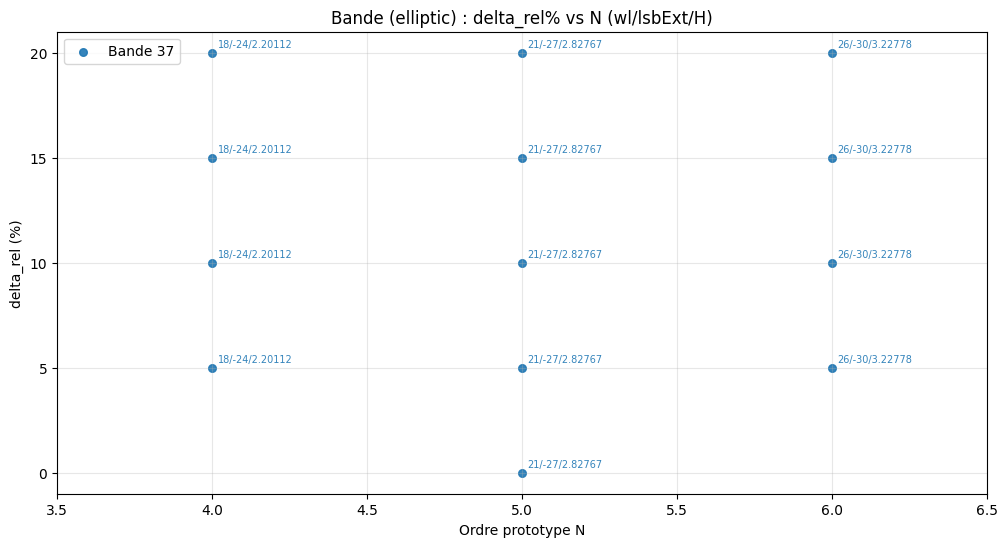

[FloPoCo] band=38 N=4 d=0.05 try quantized wl=16
  quantized coeffb hex: 0x1.4000000000000p-9:0x1.4000000000000p-10:0x1.2000000000000p-9:0x1.8000000000000p-10:0x1.1000000000000p-8:0x1.8000000000000p-10:0x1.2000000000000p-9:0x1.4000000000000p-10:0x1.4000000000000p-9
  quantized coeffa hex: 0x1.9080000000000p-1:0x1.dcd8000000000p+1:0x1.0e38000000000p+1:0x1.4918000000000p+2:0x1.edb0000000000p+0:0x1.8e50000000000p+1:0x1.3080000000000p-1:0x1.63a0000000000p-1
[FloPoCo] band=38 N=4 d=0.1 try quantized wl=16
  quantized coeffb hex: 0x1.4000000000000p-9:0x1.4000000000000p-10:0x1.2000000000000p-9:0x1.8000000000000p-10:0x1.1000000000000p-8:0x1.8000000000000p-10:0x1.2000000000000p-9:0x1.4000000000000p-10:0x1.4000000000000p-9
  quantized coeffa hex: 0x1.9080000000000p-1:0x1.dcd8000000000p+1:0x1.0e38000000000p+1:0x1.4918000000000p+2:0x1.edb0000000000p+0:0x1.8e50000000000p+1:0x1.3080000000000p-1:0x1.63a0000000000p-1
[FloPoCo] band=38 N=4 d=0.15 try quantized wl=16
  quantized coeffb hex: 0x1.40000000

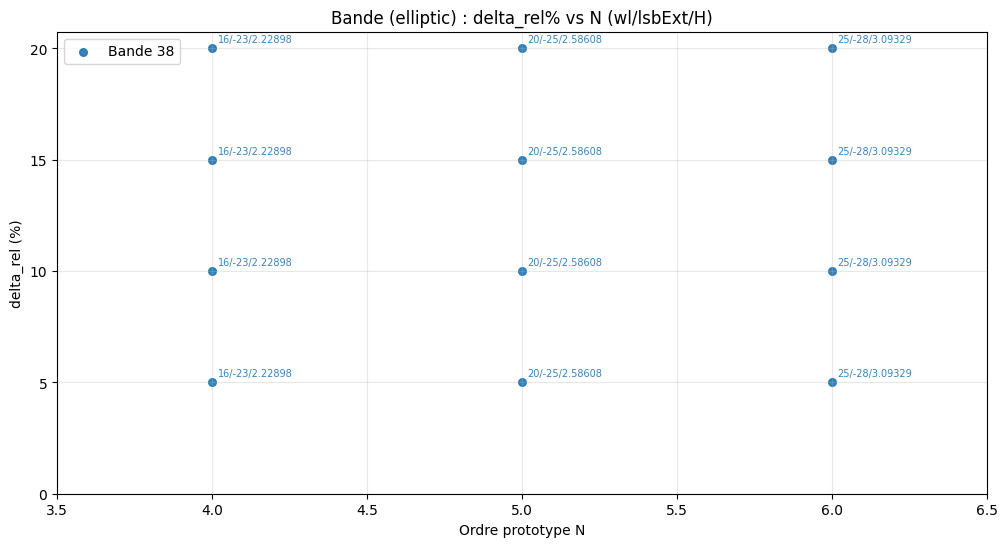

[FloPoCo] band=39 N=4 d=0.05 try quantized wl=18
  quantized coeffb hex: 0x1.d000000000000p-9:0x1.f000000000000p-8:0x1.e000000000000p-8:0x1.1800000000000p-7:0x1.6c00000000000p-7:0x1.1800000000000p-7:0x1.e000000000000p-8:0x1.f000000000000p-8:0x1.d000000000000p-9
  quantized coeffa hex: 0x1.ee54000000000p+1:0x1.1f39000000000p+3:0x1.b245000000000p+3:0x1.e3e1000000000p+3:0x1.8351000000000p+3:0x1.c8ce000000000p+2:0x1.5de8000000000p+1:0x1.4390000000000p-1
[FloPoCo] band=39 N=4 d=0.1 try quantized wl=17
  quantized coeffb hex: 0x1.e000000000000p-9:0x1.f000000000000p-8:0x1.e000000000000p-8:0x1.1800000000000p-7:0x1.7000000000000p-7:0x1.1800000000000p-7:0x1.e000000000000p-8:0x1.f000000000000p-8:0x1.e000000000000p-9
  quantized coeffa hex: 0x1.ee58000000000p+1:0x1.1f38000000000p+3:0x1.b244000000000p+3:0x1.e3e2000000000p+3:0x1.8352000000000p+3:0x1.c8d0000000000p+2:0x1.5de8000000000p+1:0x1.43a0000000000p-1
[FloPoCo] band=39 N=4 d=0.15 try quantized wl=16
  quantized coeffb hex: 0x1.c000000000000p-9

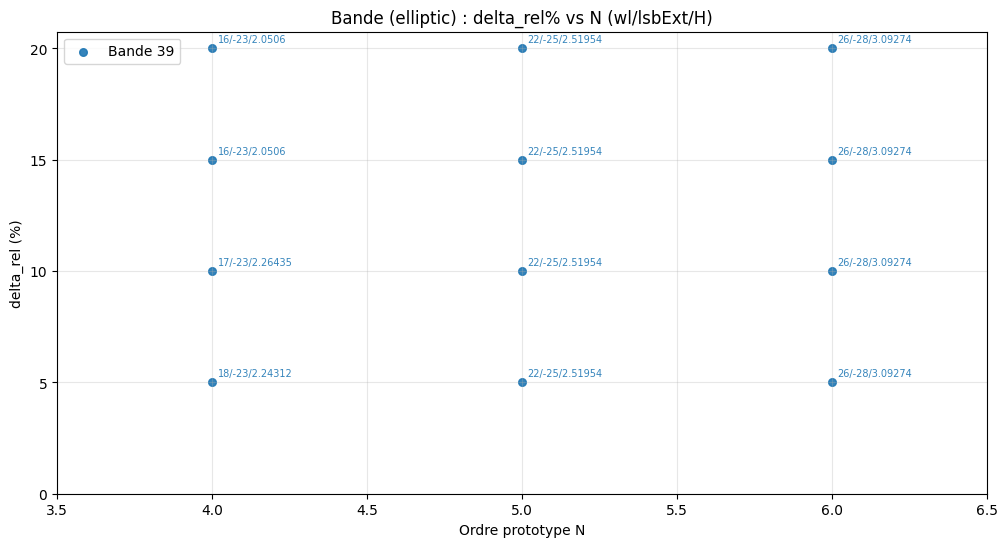

Ranges: {39: (4, 6)}
Nb points valides: 12


In [10]:
for i in range(37, 40):
    ranges_1, points_1 = plot_elliptic_simulation(
        bands_to_plot=(i,),
        fs=fs,
        delta_list=(0.00, 0.05, 0.10, 0.15, 0.20),
        ripple_db=ripple_db,
        att_db=att_db,
        wl_max=53,
        use_ord_Wn=True,
        N_search_max=60,
        title="Bande (elliptic) : delta_rel% vs N (wl/lsbExt/H)",
    )
print("Ranges:", ranges_1)
print("Nb points valides:", len(points_1))

Bande 37, N=4, delta_rel=0.05
fl = 4489.85 Hz, f0 = 5039.68 Hz, fu = 5656.85 Hz
Flottant: stable=True, max|p|=0.981630
ANSI (flottant): {'ripple_pp_db': 0.9999803748966597, 'att_stop_db': 59.02018882384524, 'stable': True, 'valid': True, 'spec_ripple_pp_max_db': 2.1, 'spec_att_min_db': 57.0}
Quantifié minimal trouvé : wl=18 (integer_bits=4, frac_bits=14)
Quantifié: stable=True, max|p|=0.982788
ANSI (quantifié): {'ripple_pp_db': 2.011905216538242, 'att_stop_db': 57.0995932818768, 'stable': True, 'valid': True, 'spec_ripple_pp_max_db': 2.1, 'spec_att_min_db': 57.0}


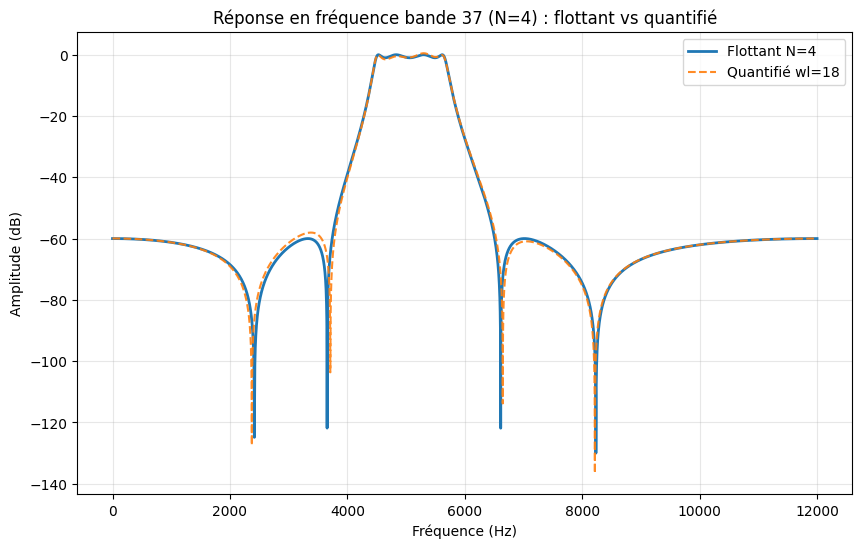

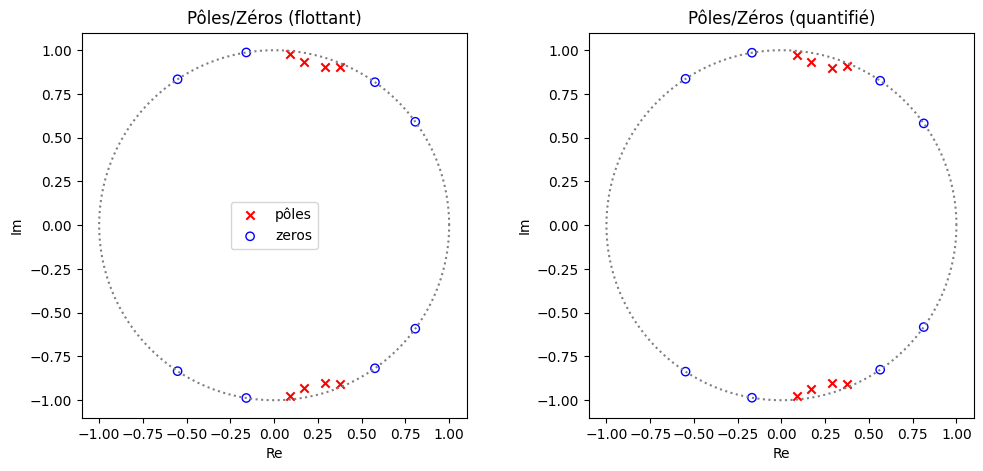

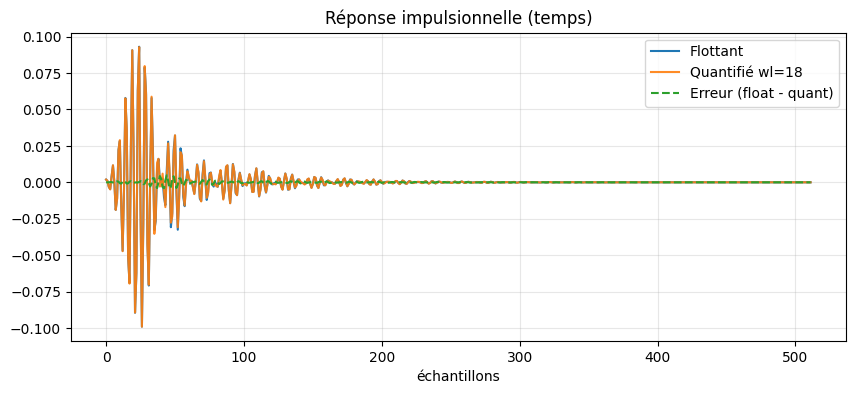


Valeurs quantifiées (float) :
b (quantized float): [0.00189208984375, -0.00250244140625, 0.0042724609375, -0.00445556640625, 0.00604248046875, -0.00445556640625, 0.0042724609375, -0.00250244140625, 0.00189208984375]
a (quantized float): [1.0, -1.85211181640625, 4.9122314453125, -5.4775390625, 7.43878173828125, -5.096435546875, 4.253662109375, -1.490234375, 0.7486572265625]

Float hex (coeff quantifiés) :
b hex : ['0x1.f000000000000p-10', '-0x1.4800000000000p-9', '0x1.1800000000000p-8', '-0x1.2400000000000p-8', '0x1.8c00000000000p-8', '-0x1.2400000000000p-8', '0x1.1800000000000p-8', '-0x1.4800000000000p-9', '0x1.f000000000000p-10']
a hex : ['0x1.0000000000000p+0', '-0x1.da24000000000p+0', '0x1.3a62000000000p+2', '-0x1.5e90000000000p+2', '0x1.dc15000000000p+2', '-0x1.462c000000000p+2', '0x1.103c000000000p+2', '-0x1.7d80000000000p+0', '0x1.7f50000000000p-1']


In [46]:
band = 37
N = 4  
delta_rel_test = 0.05

print(f"Bande {band}, N={N}, delta_rel={delta_rel_test}")

# --- Fréquences de la bande ---
fl, f0, fu = ansi_band(band)
print(f"fl = {fl:.2f} Hz, f0 = {f0:.2f} Hz, fu = {fu:.2f} Hz")

# --- Design floating-point ---
b_f, a_f = design_elliptic_bandpass(fl, fu, fs, N=N, ripple_db=ripple_db, att_db=att_db, use_ord_Wn=True)

poles_f, max_abs_pole_f, stable_f = check_iir_stability_ba(a_f)
print(f"Flottant: stable={stable_f}, max|p|={max_abs_pole_f:.6f}")
res_f = verify_ansi_standard(b_f, fl, fu, fs, delta_rel=delta_rel_test, a=a_f, ripple_db=ripple_db, att_db=att_db)
print("ANSI (flottant):", res_f)

# --- Recherche minimal WL qui passe ---
out = find_min_word_length_for_valid_elliptic(fl, fu, fs, N=N, delta_rel=delta_rel_test, ripple_db=ripple_db, att_db=att_db, wl_max=53, use_ord_Wn=True)
if out is None:
    print("Aucun WL <= 53 ne passe pour ces specs (N, delta_rel). On peut augmenter wl_max si souhaité.")
    wl_min = None
    b_q = a_q = None
else:
    wl_min, integer_bits, frac_bits = out
    b_q, a_q, _ = quantize_iir_ba(b_f, a_f, wl=wl_min, integer_bits=integer_bits, wrap=False)
    poles_q, max_abs_pole_q, stable_q = check_iir_stability_ba(a_q)
    res_q = verify_ansi_standard(b_q, fl, fu, fs, delta_rel=delta_rel_test, a=a_q, ripple_db=ripple_db, att_db=att_db)
    print(f"Quantifié minimal trouvé : wl={wl_min} (integer_bits={integer_bits}, frac_bits={frac_bits})")
    print(f"Quantifié: stable={stable_q}, max|p|={max_abs_pole_q:.6f}")
    print("ANSI (quantifié):", res_q)

# --- Tracé réponses en fréquence ---
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
w, Hf = freqz(b_f, a_f, worN=8192, fs=fs)
ax.plot(w, 20 * np.log10(np.maximum(np.abs(Hf), 1e-12)), label=f"Flottant N={N}", lw=2)
if out is not None:
    w, Hq = freqz(b_q, a_q, worN=8192, fs=fs)
    ax.plot(w, 20 * np.log10(np.maximum(np.abs(Hq), 1e-12)), linestyle='--', label=f"Quantifié wl={wl_min}", lw=1.5, alpha=0.9)
# Marqueurs des bornes
ax.set_xlabel('Fréquence (Hz)')
ax.set_ylabel('Amplitude (dB)')
ax.set_title(f"Réponse en fréquence bande {band} (N={N}) : flottant vs quantifié")
ax.grid(True, which='both', alpha=0.3)
ax.legend()
plt.show()

# --- Diagramme pôles/zéros ---
fig, axes = plt.subplots(1, 2 if out is not None else 1, figsize=(12, 5))
if out is not None:
    ax1, ax2 = axes
else:
    ax1 = axes

z_f, p_f, k_f = tf2zpk(b_f, a_f)
ax1.scatter(np.real(p_f), np.imag(p_f), marker='x', color='r', label='pôles'), ax1.scatter(np.real(z_f), np.imag(z_f), marker='o', facecolors='none', edgecolors='b', label='zeros')
ax1.set_title('Pôles/Zéros (flottant)')
ax1.set_xlabel('Re'), ax1.set_ylabel('Im')
# unit circle
theta = np.linspace(0, 2*np.pi, 201)
ax1.plot(np.cos(theta), np.sin(theta), ':', color='gray')
ax1.set_aspect('equal', 'box')
ax1.legend()

if out is not None:
    z_q, p_q, k_q = tf2zpk(b_q, a_q)
    ax2.scatter(np.real(p_q), np.imag(p_q), marker='x', color='r'), ax2.scatter(np.real(z_q), np.imag(z_q), marker='o', facecolors='none', edgecolors='b')
    ax2.set_title('Pôles/Zéros (quantifié)')
    ax2.set_xlabel('Re'), ax2.set_ylabel('Im')
    ax2.plot(np.cos(theta), np.sin(theta), ':', color='gray')
    ax2.set_aspect('equal', 'box')

plt.show()

# --- Réponse impulsionnelle et erreur temporelle ---
imp_len = 512
imp = np.zeros(imp_len); imp[0] = 1.0
h_float = lfilter(b_f, a_f, imp)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(h_float, label='Flottant')
if out is not None:
    h_quant = lfilter(b_q, a_q, imp)
    ax.plot(h_quant, label=f'Quantifié wl={wl_min}', alpha=0.9)
    ax.plot(h_float - h_quant, label='Erreur (float - quant)', linestyle='--')
ax.set_title('Réponse impulsionnelle (temps)')
ax.set_xlabel('échantillons')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

# --- Résumé / Coefficients quantifiés (binaire) ---
if out is not None:
    scale = 2 ** frac_bits
    fixed_b = (np.round(b_q * scale)).astype(int)
    fixed_a = (np.round(a_q * scale)).astype(int)

    # Vraies valeurs quantifiées (float) : les coefficients après quantification
    print('\nValeurs quantifiées (float) :')
    print('b (quantized float):', [float(x) for x in b_q])
    print('a (quantized float):', [float(x) for x in a_q])

    # Représentation hex de ces floats (utile pour vérification rapide)
    print('\nFloat hex (coeff quantifiés) :')
    print('b hex :', [c.hex() for c in b_q])
    print('a hex :', [c.hex() for c in a_q])


In [47]:
def q_msb_lsb(x, msb, lsb, wrap=False):
    """
    Quantifie x en utilisant une description de format type FloPoCo (msb/lsb).

    - msb : indice du bit de poids fort (incluant le bit de signe)
    - lsb : indice du bit de poids faible (souvent négatif)

    Exemple : msb=0, lsb=-12  -> wl = 13 bits, ib = 1  -> Q1.12
    """
    wl = msb - lsb + 1       # longueur totale
    ib = msb + 1             # nb de bits entiers incluant le signe
    return quantize(x, wl, integer_bits=ib, wrap=wrap)


In [48]:

class IIR_DFI_Float:
    """
    Filtre IIR en forme directe I (Direct Form I) en virgule flottante.

    Cette classe implémente un filtre IIR causal de type :
        y[n] = Σ b[i] u[n−i] - Σ a[j] y[n−j]

    avec :
        - b : coefficients feedforward
        - a : coefficients feedback (a[0] = 1)

    L'implémentation est strictement en flottant (float64),
    sans aucune quantification, et sert de référence (baseline)
    pour comparer avec la version virgule fixe.

    Le filtre est évalué échantillon par échantillon via la méthode `step`,
    ce qui correspond à un fonctionnement temps réel / matériel.

    Attributs
    ----------
    b : np.ndarray
        Coefficients feedforward [b0, b1, ..., b_M]
    a : np.ndarray
        Coefficients feedback [1, a1, ..., a_N]
    nb : int
        Nombre de coefficients feedforward
    na : int
        Nombre de coefficients feedback (hors a0)
    u_buf : np.ndarray
        Buffer des entrées u[n−i]
    y_buf : np.ndarray
        Buffer des sorties y[n−i]

    Méthodes
    --------
    step(u):
        Traite un échantillon d’entrée u et retourne la sortie y[n].
    """
    def __init__(self, b, a):
        self.b = np.asarray(b, float)
        self.a = np.asarray(a, float)

        self.nb = len(self.b)
        self.na = len(self.a) - 1

        self.u_buf = np.zeros(self.nb)
        self.y_buf = np.zeros(self.na)

    def step(self, u):
        # buffer entrée
        if self.nb > 1:
            self.u_buf[1:] = self.u_buf[:-1]
        self.u_buf[0] = u

        # feedforward
        acc_ff = float(np.sum(self.b * self.u_buf))

        # feedback (a0=1)
        acc_fb = 0.0
        if self.na > 0:
            acc_fb = float(np.sum(self.a[1:] * self.y_buf))

        y = acc_ff - acc_fb

        # maj buffer feedback
        if self.na > 1:
            self.y_buf[1:] = self.y_buf[:-1]
        if self.na > 0:
            self.y_buf[0] = y

        return y


In [49]:

class IIR_DFI_Fixed:
    """
    Filtre IIR en forme directe I (Direct Form I) simulé en virgule fixe.

    Cette classe simule une implémentation matérielle
    d’un filtre IIR, en modélisant explicitement :
      - la quantification de l’entrée
      - la quantification des produits b·u et a·y
      - la quantification de la somme interne (bits de garde)
      - la quantification de la sortie
      - la récursion interne sur la valeur quantifiée

    Le calcul est effectué échantillon par échantillon (`step`),
    comme dans un circuit synchrone réel.

    Les formats sont définis sous la forme (msb, lsb),
    où :
      - msb = poids du bit de signe / partie entière
      - lsb = poids du bit de moindre poids (LSB)

    Cette classe permet d’étudier :
      - l’erreur numérique par rapport au flottant
      - la sensibilité à la quantification
      - la stabilité numérique des structures IIR
      - la cohérence avec les résultats FloPoCo (FixIIR)

    Paramètres
    ----------
    b : array-like
        Coefficients feedforward (float, supposés déjà conçus)
    a : array-like
        Coefficients feedback (float), avec a[0] = 1
    fmt_in : (msb, lsb)
        Format de quantification de l’entrée u[n]
    fmt_bmul : (msb, lsb)
        Format des produits b[i]·u[n−i]
    fmt_amul : (msb, lsb)
        Format des produits a[j]·ỹ[n−j]
    fmt_ext : (msb, lsb)
        Format interne étendu (bits de garde) pour la récursion
    fmt_out : (msb, lsb)
        Format de la sortie y[n]
    wrap : bool
        Si True : wrap-around complément à 2
        Si False : saturation (recommandé pour la stabilité)

    Fonctionnement interne (par appel à step)
    -----------------------------------------
    1) Quantification de l’entrée
    2) Calcul feedforward avec quantification des produits
    3) Calcul feedback avec quantification des produits
    4) Somme interne et quantification sur format étendu
    5) Mise à jour de la récursion avec la valeur quantifiée
    6) Quantification de la sortie

    Méthodes
    --------
    step(u):
        Traite un échantillon d’entrée u et retourne la sortie quantifiée y[n].
    """
    def __init__(
        self,
        b, a,
        fmt_in: Tuple[int,int],
        fmt_bmul: Tuple[int,int],
        fmt_amul: Tuple[int,int],
        fmt_ext: Tuple[int,int],
        fmt_out: Tuple[int,int],
        wrap: bool = False
    ):
        self.b = np.asarray(b, float)
        self.a = np.asarray(a, float)

        self.nb = len(self.b)
        self.na = len(self.a) - 1

        self.u_buf = np.zeros(self.nb)
        self.y_buf = np.zeros(self.na)

        self.msb_in, self.lsb_in = fmt_in
        self.msb_bmul, self.lsb_b = fmt_bmul
        self.msb_amul, self.lsb_a = fmt_amul
        self.msb_ext, self.lsb_ext = fmt_ext
        self.msb_out, self.lsb_out = fmt_out

        self.wrap = wrap

    def step(self, u):
        # (1) quantif entrée
        u_q = q_msb_lsb(u, self.msb_in, self.lsb_in, wrap=self.wrap)

        # buffer entrée
        if self.nb > 1:
            self.u_buf[1:] = self.u_buf[:-1]
        self.u_buf[0] = u_q

        # (2) multiplications feedforward quantifiées sur lsb_b
        acc_ff = 0.0
        for i in range(self.nb):
            p = self.b[i] * self.u_buf[i]
            p = q_msb_lsb(p, self.msb_bmul, self.lsb_b, wrap=self.wrap)
            acc_ff += p

        # (2) multiplications feedback quantifiées sur lsb_a
        acc_fb = 0.0
        for i in range(self.na):
            p = self.a[i+1] * self.y_buf[i]
            p = q_msb_lsb(p, self.msb_amul, self.lsb_a, wrap=self.wrap)
            acc_fb += p

        # (3) somme interne avant récursion (lsb_ext)
        s = acc_ff - acc_fb
        y_tilde = q_msb_lsb(s, self.msb_ext, self.lsb_ext, wrap=self.wrap)

        # maj buffer feedback avec y_tilde (c’est ça qui tourne dans la boucle)
        if self.na > 1:
            self.y_buf[1:] = self.y_buf[:-1]
        if self.na > 0:
            self.y_buf[0] = y_tilde

        # (4) sortie quantifiée
        y_out = q_msb_lsb(y_tilde, self.msb_out, self.lsb_out, wrap=self.wrap)
        return y_out


In [50]:
def octave_bands_from_ansi(top_band=39, n_octaves=6):
    """
    Génère la répartition des bandes ANSI en groupes d'octaves successives.

    Chaque octave regroupe exactement 3 bandes ANSI consécutives,
    en partant de la bande la plus haute (`top_band`) vers les basses fréquences.
    
    Convention adoptée (conforme au papier) :
        - Octave 0 : bandes [top_band-2, top_band-1, top_band]
          typiquement [37, 38, 39]
        - Octave 1 : bandes [34, 35, 36]
        - etc.
    
    Paramètres :
        top_band : int
            Indice de la bande ANSI la plus haute (par défaut 39).
        n_octaves : int
            Nombre total d'octaves à générer.
    
    Retour : 
        oct_bands : list of list of int
            Liste de longueur `n_octaves` telle que :
            oct_bands[k] = [band_1, band_2, band_3] pour l'octave k.
        
    """
    oct_bands = []
    for k in range(n_octaves):
        b3 = top_band - 3*k
        oct_bands.append([b3-2, b3-1, b3])
    return oct_bands

def design_decimation_filter_D(fs_k, fl_band=None, kind="iir", ntaps=63, cutoff_ratio=None):
    """
    Fonction qui conçoit le filtre D utilisé avant une décimation par 2 (anti-repliement).

    La fréquence de coupure peut être définie soit :
    - Par la limite basse (fl) de la bande ANSI la plus basse de l'octave (recommandé)
    - Par un ratio appliqué à fs_k/4 (ancienne méthode, pour compatibilité)
    
    Paramètres :
        fs_k : float
            Fréquence d'échantillonnage à l'entrée de l'octave k.
        fl_band : float, optional
            Limite basse (fl) de la bande ANSI la plus basse de l'octave.
            Si fourni, ce paramètre prend priorité sur cutoff_ratio.
        kind : {"iir", "fir"}
            Type de filtre :
            - "iir" : Elliptique (plus compact, plus raide)
            - "fir" : FIR fenêtre de Hamming (linéaire en phase)
        ntaps : int
            Nombre de coefficients pour le FIR (ignoré si kind="iir").
        cutoff_ratio : float, optional
            Rapport appliqué à fs_k/4 pour fixer la coupure effective.
            Utilisé uniquement si fl_band n'est pas fourni.
            Exemple : 0.5 → coupure à 0.5·(fs_k/4).
            
    Retour :
        b, a : np.ndarray
            Coefficients du filtre D sous forme (b, a).
    """
    # Priorité à fl_band si fourni, sinon utiliser cutoff_ratio
    if fl_band is not None:
        cutoff = fl_band
    elif cutoff_ratio is not None:
        cutoff = cutoff_ratio * (fs_k / 4)
    else:
        raise ValueError("Vous devez fournir soit fl_band, soit cutoff_ratio")

    if kind == "fir":
        b = firwin(ntaps, cutoff/(fs_k/2), window="hamming", pass_zero=True)
        a = np.array([1.0])
    elif kind == "iir":
        # ordre un peu plus costaud
        b, a = ellip(
            N=8,
            rp=1,
            rs=60,
            Wn=cutoff/(fs_k/2),
            btype="low",
            output="ba"
        )
    else:
        raise ValueError("kind must be 'fir' or 'iir'")
    return b, a


In [51]:
def make_band_filter_from_ansi(
    band: int,
    fs_k: float,
    order: int = 5,
    rp: float = 1.0,
    rs: float = 60.0
):
    """
    Conçoit un filtre passe-bande elliptique correspondant à une bande ANSI 1/3 d’octave.

    Ce filtre modélise les filtres Fxx du papier (ex: F37, F38, F39)

    Paramètres :
        band : int
            Indice de la bande ANSI (ex : 37, 38, 39).
        fs_k : float
            Fréquence d’échantillonnage de l’octave considérée (fs / 2^k).
        order : int, optionnel
            Ordre du filtre elliptique (4 à 6 typique).
        rp : float, optionnel
            Ondulation maximale en bande passante (dB).
        rs : float, optionnel
            Atténuation minimale en bande coupée (dB).

    Retour :
        b, a : np.ndarray
            Coefficients (numérateur, dénominateur) du filtre passe-bande elliptique.
    """
    # fréquences ANSI (Hz)
    fl, f0, fu = ansi_band(band)

    # normalisation par Nyquist
    Wn = [fl / (fs_k / 2), fu / (fs_k / 2)]

    # sécurité numérique
    Wn[0] = max(Wn[0], 1e-6)
    Wn[1] = min(Wn[1], 0.999)

    b, a = ellip(
        N=order,
        rp=rp,
        rs=rs,
        Wn=Wn,
        btype="bandpass",
        output="ba"
    )

    return b, a


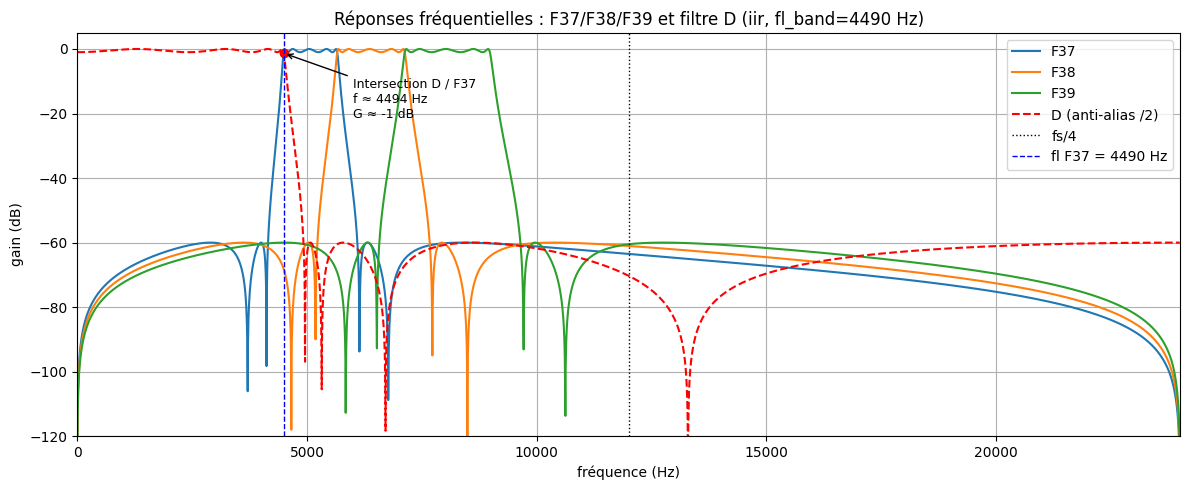

In [55]:
def plot_F37_F38_F39_and_D(fs, make_band_filter, D_kind="iir", cutoff_ratio=None, use_fl_band=True):
    """
    Trace les réponses fréquentielles des filtres F37, F38, F39 ainsi que
    du filtre de décimation D, tous évalués à la fréquence fs.

    En plus de l'affichage classique en dB, la fonction :
      - détecte le premier point fréquentiel où le filtre D
        passe sous la réponse de F37,
      - marque graphiquement ce point d'intersection,
      - affiche un repère vertical correspondant à fs/4
        (limite de Nyquist après décimation par 2).
      - affiche un repère vertical à fl (bande la plus basse) utilisé pour le filtre D

    Paramètres :
        fs : float
            Fréquence d'échantillonnage de l'octave 0.
        make_band_filter : callable
            Fonction de conception des filtres de bande :
            (band, fs) → (b, a).
        D_kind : {"iir", "fir"}
            Type de filtre utilisé pour D.
        cutoff_ratio : float, optional
            Rapport de coupure du filtre D par rapport à fs/4.
            Utilisé uniquement si use_fl_band=False.
        use_fl_band : bool
            Si True (par défaut), utilise la limite basse de F37 comme fréquence de coupure.
            Si False, utilise cutoff_ratio.

    Retour :
        Aucun (affichage graphique uniquement).
    """
    bands = [37, 38, 39]

    plt.figure(figsize=(12, 5))

    # calcul F37 (pour intersection)
    b37, a37 = make_band_filter(37, fs)
    w, h37 = freqz(b37, a37, worN=4096, fs=fs)
    H37db = 20*np.log10(np.maximum(np.abs(h37), 1e-12))
    plt.plot(w, H37db, label="F37")

    # autres bandes
    for bnd in [38, 39]:
        b, a = make_band_filter(bnd, fs)
        _, h = freqz(b, a, worN=4096, fs=fs)
        Hdb = 20*np.log10(np.maximum(np.abs(h), 1e-12))
        plt.plot(w, Hdb, label=f"F{bnd}")

    # filtre D - utiliser fl de la bande 37 (la plus basse de l'octave 0)
    if use_fl_band:
        fl_37, _, _ = ansi_band(37)
        bD, aD = design_decimation_filter_D(fs, fl_band=fl_37, kind=D_kind)
        title_suffix = f"({D_kind}, fl_band={fl_37:.0f} Hz)"
    else:
        if cutoff_ratio is None:
            cutoff_ratio = 0.5  # valeur par défaut
        bD, aD = design_decimation_filter_D(fs, kind=D_kind, cutoff_ratio=cutoff_ratio)
        title_suffix = f"({D_kind}, cutoff_ratio={cutoff_ratio})"
    
    _, hD = freqz(bD, aD, worN=4096, fs=fs)
    HDdb = 20*np.log10(np.maximum(np.abs(hD), 1e-12))
    plt.plot(w, HDdb, "--", label="D (anti-alias /2)", color="red")

    # intersection F37 / D 
    diff = HDdb - H37db
    idx = np.where(diff <= 0)[0]
    if len(idx) > 0:
        i0 = idx[0]
        f_int = w[i0]
        g_int = HDdb[i0]

        plt.plot(f_int, g_int, "ro")
        plt.annotate(
            f"Intersection D / F37\nf ≈ {f_int:.0f} Hz\nG ≈ {g_int:.0f} dB",
            xy=(f_int, g_int),
            xytext=(f_int + 1500, g_int - 20),
            arrowprops=dict(arrowstyle="->", color="black"),
            fontsize=9,
        )

    # repère Nyquist après /2 
    plt.axvline(fs/4, color="k", linestyle=":", linewidth=1, label="fs/4")
    # repère fl de F37 (fréquence de coupure du filtre D)
    if use_fl_band:
        plt.axvline(fl_37, color="blue", linestyle="--", linewidth=1, label=f"fl F37 = {fl_37:.0f} Hz")

    plt.ylim(-120, 5)
    plt.xlim(0, fs/2)
    plt.grid(True)
    plt.xlabel("fréquence (Hz)")
    plt.ylabel("gain (dB)")
    plt.title(
        f"Réponses fréquentielles : F37/F38/F39 et filtre D {title_suffix}"
    )
    plt.legend()
    plt.tight_layout()
    plt.show()

    
# Paramètres
fs = 48000          # fréquence d'échantillonnage
D_kind = "iir"      # ou "fir" si tu veux comparer

# Tracé des filtres F37 / F38 / F39 et du filtre de décimation D
# Par défaut, utilise maintenant la limite basse de F37
plot_F37_F38_F39_and_D(
    fs=fs,
    make_band_filter=make_band_filter_from_ansi,
    D_kind=D_kind,
    use_fl_band=True  # Utilise la limite basse de F37
)


In [56]:
class DecimatorBy2:
    """
    Bloc de décimation par 2 avec filtrage anti-repliement préalable.

    Le bloc applique d’abord un filtre D à chaque échantillon entrant,
    puis ne conserve qu’un échantillon sur deux selon une phase interne.

    Le fonctionnement est strictement séquentiel (streaming).
    
    Méthodes :
        push(u):
            Traite un échantillon d’entrée.
            Retourne :
            - has_output : bool
                True uniquement lorsque la décimation produit une sortie.
            - y_ds : float or None
                Échantillon décimé si has_output=True, sinon None.
    
    """
    def __init__(self, D_filter):
        self.D = D_filter
        self.phase = 0

    def push(self, u):
        # si aucune entrée valide → aucun calcul
        if u is None:
            return False, None

        y = self.D.step(u)

        if self.phase == 0:
            out = y
            has = True
        else:
            out = None
            has = False

        self.phase ^= 1
        return has, out

In [57]:

def build_bank_like_paper(
    fs: int,
    n_octaves: int,
    make_band_filter,   # callback: (band, fs_k) -> (b,a) en float
    fixed: bool = False,
    fmt=None,
    D_kind="iir",
    cutoff_ratio=None    
):
    """
    Construit un banc de filtres multirate comme sur le papier.

    Architecture implémentée :
      - À l'octave 0 (fs) : application simultanée des filtres F37, F38, F39.
      - La sortie est filtrée par D puis décimée par 2.
      - Le signal décimé alimente l'octave suivante (fs/2),
        qui applique les bandes ANSI suivantes (F34–F36), etc.

    Chaque octave possède :
      - trois filtres passe-bande ANSI,
      - un filtre D suivi d'une décimation /2 (sauf dernière octave).

    La fonction peut construire soit :
      - une version flottante de référence,
      - une version virgule fixe simulée, si `fixed=True`.

    Paramètres :
        fs : int
            Fréquence d'échantillonnage initiale.
        n_octaves : int
            Nombre d'octaves du banc de filtres.
        make_band_filter : callable
            Fonction de conception des filtres ANSI.
        fixed : bool
            Active la version virgule fixe si True.
        fmt : tuple or None
            Formats fixes (fmt_in, fmt_bmul, fmt_amul, fmt_ext, fmt_out).
        D_kind : {"iir", "fir"}
            Type de filtre utilisé pour le filtre D.
        cutoff_ratio : float, optional
            Si fourni, utilisé comme ratio de fs_k/4 pour la coupure du filtre D.
            Sinon, la limite basse de la bande ANSI la plus basse est utilisée.

    Retour :
        octaves_filters : list
            Liste des filtres par octave.
        decimators : list
            Liste des blocs de décimation entre octaves.
        oct_bands : list
            Répartition des bandes ANSI par octave.
    """

    oct_bands = octave_bands_from_ansi(top_band=39, n_octaves=n_octaves)

    octaves_filters: List[List[object]] = []
    decimators: List[DecimatorBy2] = []

    for k in range(n_octaves):
        fs_k = fs // (2**k)

        # --- filtres de bandes (3 par octave) ---
        band_objs = []
        for band in oct_bands[k]:
            b, a = make_band_filter(band, fs_k)  # design float
            if not fixed:
                band_objs.append(IIR_DFI_Float(b, a))
            else:
                # fmt = (fmt_in, fmt_bmul, fmt_amul, fmt_ext, fmt_out)
                (fmt_in, fmt_bmul, fmt_amul, fmt_ext, fmt_out) = fmt
                band_objs.append(IIR_DFI_Fixed(b, a, fmt_in, fmt_bmul, fmt_amul, fmt_ext, fmt_out))
        octaves_filters.append(band_objs)

        # --- filtre D + décimation (pas besoin après dernière octave) ---
        if k < n_octaves - 1:
            # Récupérer la limite basse de la bande la plus basse de cette octave
            lowest_band = oct_bands[k][0]  # Première bande (la plus basse) de l'octave
            fl_band, _, _ = ansi_band(lowest_band)
            
            # Design du filtre D : priorité à fl_band, sinon cutoff_ratio si fourni
            if cutoff_ratio is not None:
                bD, aD = design_decimation_filter_D(fs_k, kind=D_kind, cutoff_ratio=cutoff_ratio)
            else:
                bD, aD = design_decimation_filter_D(fs_k, fl_band=fl_band, kind=D_kind)
            
            if not fixed:
                D_obj = IIR_DFI_Float(bD, aD)
            else:
                (fmt_in, fmt_bmul, fmt_amul, fmt_ext, fmt_out) = fmt
                D_obj = IIR_DFI_Fixed(bD, aD, fmt_in, fmt_bmul, fmt_amul, fmt_ext, fmt_out)
            decimators.append(DecimatorBy2(D_obj))

    return octaves_filters, decimators, oct_bands


In [58]:
def simulate_multirate_paper(x: np.ndarray, fs: int, octaves_filters, decimators):
    """
    Simulation streaming fidèle au schéma :
      - Octave 0 traite chaque échantillon
      - D0 filtre puis décime -> alimente octave 1
      - D1 filtre puis décime -> alimente octave 2
      etc.

    Sortie :
      outputs[k] = np.array shape (Nk, 3)  (3 bandes par octave) au taux fs/2^k
    """
    x = np.asarray(x, float)

    n_octaves = len(octaves_filters)
    outputs = [ [] for _ in range(n_octaves) ]

    # files d’entrées “courantes” par octave (échantillon à ce taux)
    u_k = [None]*n_octaves

    for n in range(len(x)):
        # octave 0 reçoit toujours x[n]
        u_k[0] = x[n]

        # propager à travers la cascade D + /2
        for k in range(n_octaves-1):
            has, out = decimators[k].push(u_k[k])
            if has:
                u_k[k+1] = out
            else:
                u_k[k+1] = None

        # calcul des bandes aux octaves qui ont un échantillon dispo
        for k in range(n_octaves):
            if u_k[k] is None:
                continue
            bands = []
            for filt in octaves_filters[k]:
                bands.append(filt.step(u_k[k]))
            outputs[k].append(bands)

    # list -> arrays
    for k in range(n_octaves):
        outputs[k] = np.array(outputs[k], float)  # (Nk, 3)
    return outputs


In [59]:
def upsample_hold(y_oct: np.ndarray, factor: int, target_len: int):
    """
    Remet un signal multirate à la cadence de base par maintien d'ordre zéro (zero-order hold).

    Chaque échantillon du signal d'une octave donnée est répété `factor = 2^k` fois
    afin de simuler la reconstruction temporelle d'un sous-bande calculé à fs / 2^k.

    Paramètres :
    y_oct : np.ndarray, shape (N_k, M)
        Signal de sortie d'une octave k :
        - N_k : nombre d'échantillons à fs / 2^k
        - M   : nombre de bandes / filtres dans cette octave
    factor : int
        Facteur d'upsampling (typiquement 2^k).
    target_len : int
        Longueur cible en nombre d'échantillons à la fréquence de base fs.

    Retour : 
    y_rep : np.ndarray, shape (target_len, M)
        Signal ramené à la cadence fs par répétition des échantillons.
        Si nécessaire, un padding par zéros est ajouté ou la sortie est tronquée
        pour correspondre exactement à `target_len`.
    """
    if y_oct.shape[0] == 0:
        return np.zeros((target_len, y_oct.shape[1]))

    y_rep = np.repeat(y_oct, repeats=factor, axis=0)
    if y_rep.shape[0] < target_len:
        pad = target_len - y_rep.shape[0]
        y_rep = np.vstack([y_rep, np.zeros((pad, y_rep.shape[1]))])
    else:
        y_rep = y_rep[:target_len]
    return y_rep


def build_spectrogram_matrix(outputs, n_octaves: int, base_len: int):
    """
    Construit une matrice temps-bandes alignée à la fréquence de base
    à partir des sorties multirate de toutes les octaves.

    Chaque octave produit des signaux à une cadence différente (fs / 2^k).
    Donc cette fonction :
      remet chaque sortie à la cadence fs par maintien d'ordre zéro,
      transpose les bandes pour avoir (bandes × temps),
      empile toutes les bandes de toutes les octaves verticalement.

    Paramètres :
    outputs : list
        outputs[k] = np.ndarray de shape (N_k, M_k),
        sortie de l'octave k (M_k bandes, N_k échantillons).
    n_octaves : int
        Nombre total d'octaves du banc de filtres.
    base_len : int
        Nombre d'échantillons à la fréquence de base fs.

    Retour :
    S : np.ndarray, shape (sum_k M_k, base_len)
        Matrice spectrogramme :
        - lignes   : bandes (toutes octaves empilées)
        - colonnes : temps à la fréquence de base fs
    """
    bands_time = []
    for k in range(n_octaves):
        factor = 2**k
        yk = outputs[k]                     # (Nk, M_k)
        yk_up = upsample_hold(yk, factor, base_len)  # (base_len, M_k)
        bands_time.append(yk_up.T)          # (M_k, base_len)
    return np.vstack(bands_time)           # (nb_bandes_total, base_len)


def plot_spectrogram_db(signal, fs, title, nperseg=512, noverlap=None):
    """
    Affiche un spectrogramme temps-fréquence en dB utilisant scipy.signal.spectrogram.
    
    Paramètres :
    -----------
    signal : np.ndarray (1D)
        Signal temporel à analyser
    fs : int
        Fréquence d'échantillonnage en Hz
    title : str
        Titre du graphique
    nperseg : int
        Longueur de chaque segment pour la STFT (par défaut 512)
    noverlap : int or None
        Nombre d'échantillons de chevauchement entre segments
        (par défaut nperseg // 2)
    """
    if noverlap is None:
        noverlap = nperseg // 2
    
    # Calculer le spectrogramme avec scipy
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
    
    # Convertir en dB (10*log10 pour la densité spectrale de puissance)
    Sxx_dB = 10 * np.log10(Sxx + 1e-12)
    
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(t, f, Sxx_dB, shading='gouraud', cmap='viridis')
    plt.colorbar(label='Puissance spectrale (dB)')
    plt.ylabel('Fréquence (Hz)')
    plt.xlabel('Temps (s)')
    plt.title(title)
    plt.ylim(0, fs/2)
    plt.tight_layout()
    plt.show()


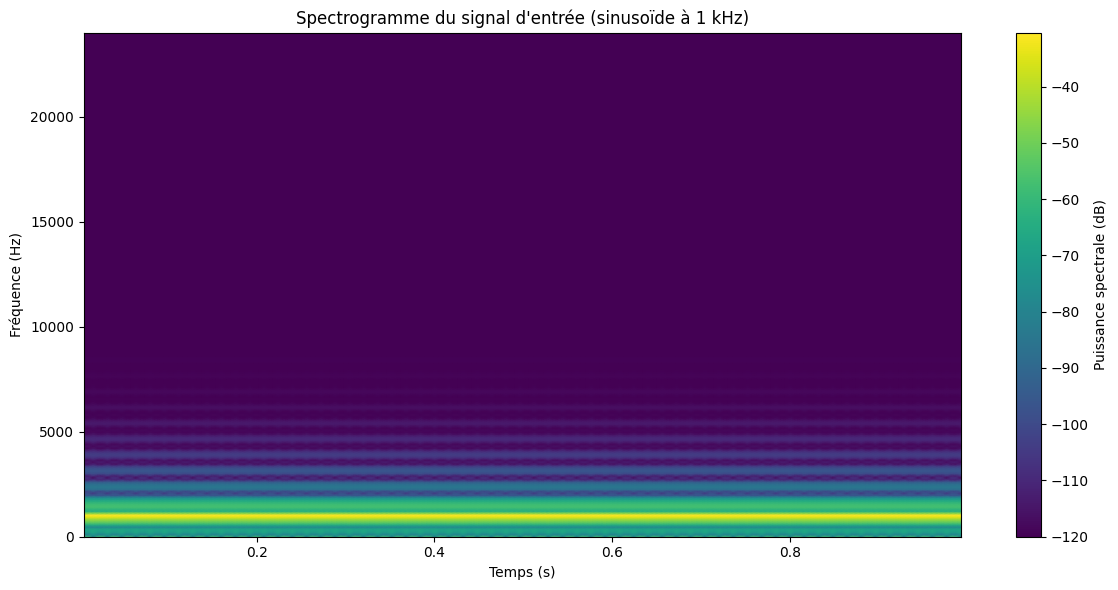

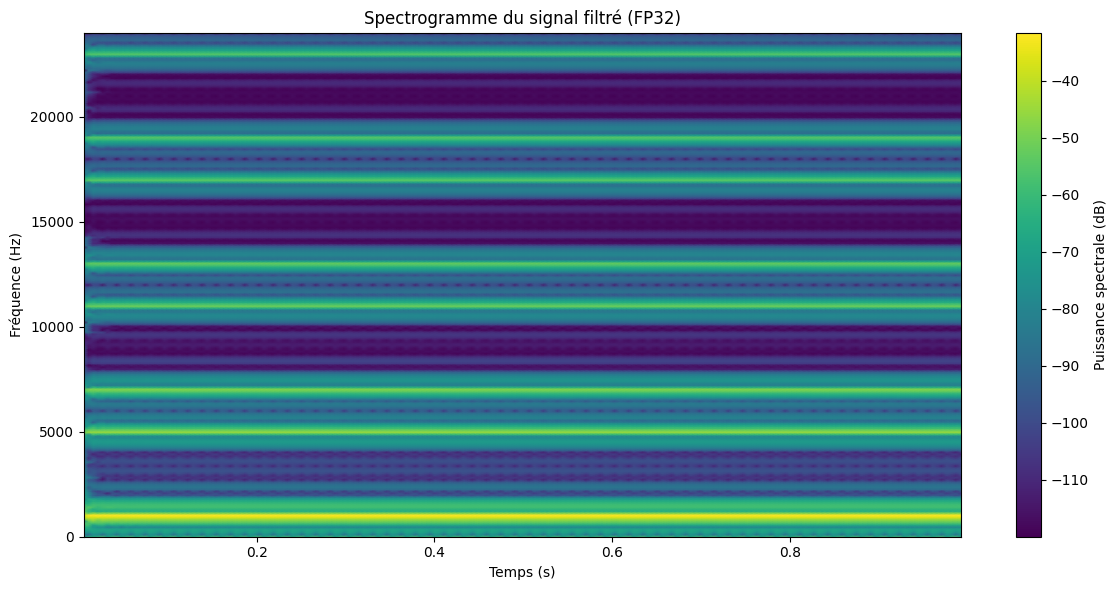

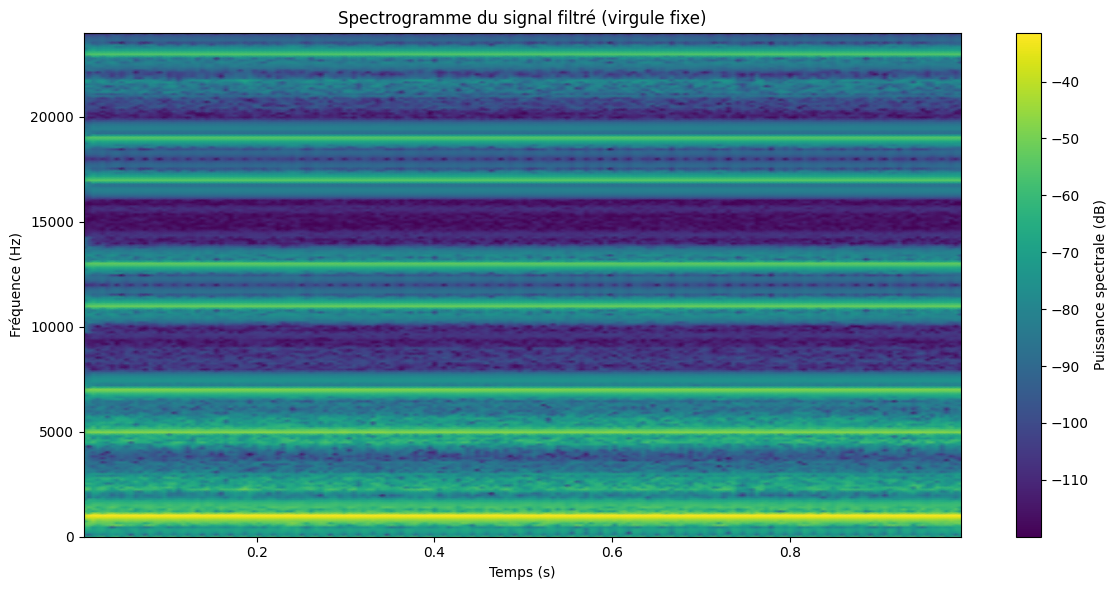

In [60]:
# signal test court - sinusoïde à 1 kHz
fs = 48000
duration = 1
t = np.linspace(0, duration, int(fs*duration), endpoint=False)
x = 0.5*np.sin(2*np.pi*1000*t)

# Afficher le spectrogramme du signal d'entrée
plot_spectrogram_db(x, fs, "Spectrogramme du signal d'entrée (sinusoïde à 1 kHz)")

n_octaves = 4

# === FP32 ===
oct_filters_fp, decim_fp, oct_bands = build_bank_like_paper(
    fs=fs,
    n_octaves=n_octaves,
    make_band_filter=make_band_filter_from_ansi,
    fixed=False,
    D_kind="iir",
    cutoff_ratio=0.5
)

out_fp = simulate_multirate_paper(x, fs, oct_filters_fp, decim_fp)

# Reconstruire le signal filtré en sommant toutes les bandes
S_fp = build_spectrogram_matrix(out_fp, n_octaves=n_octaves, base_len=len(x))
y_reconstructed_fp = np.sum(S_fp, axis=0)  # Somme de toutes les bandes

plot_spectrogram_db(y_reconstructed_fp, fs, "Spectrogramme du signal filtré (FP32)")

# === FIXE ===

# sous forme msb / lsbExt
fmt_in   = (1,  -12)  # entrée du filtre u
fmt_bmul = (18,  -24)  # produits feedforward b · u
fmt_amul = (18,  -24)  # produits feedback a · ỹ
fmt_ext  = (19,  -30)  # somme interne / récursion
fmt_out  = (1,  -12)  # sortie du filtre

oct_filters_fx, decim_fx, _ = build_bank_like_paper(
    fs=fs,
    n_octaves=n_octaves,
    make_band_filter=make_band_filter_from_ansi,
    fixed=True,
    fmt=(fmt_in, fmt_bmul, fmt_amul, fmt_ext, fmt_out),
    D_kind="iir",
    cutoff_ratio=0.5
)

out_fx = simulate_multirate_paper(x, fs, oct_filters_fx, decim_fx)
S_fx = build_spectrogram_matrix(out_fx, n_octaves=n_octaves, base_len=len(x))
y_reconstructed_fx = np.sum(S_fx, axis=0)  # Somme de toutes les bandes

plot_spectrogram_db(y_reconstructed_fx, fs, "Spectrogramme du signal filtré (virgule fixe)")


In [61]:
def rms(x):
    x = np.asarray(x)
    return np.sqrt(np.mean(x**2) + 1e-30)


On cherche l'erreur spectrale par bande donc au lieu d’un RMS temporel, on compare l’énergie RMS après filtre par bande :

$$E_k = \sqrt{\frac{1}{N}\sum_{n}^{} y_{k}[n]^{2}}$$

Et pour le SNR global par octave on a donc : 
$$SNR = 20 log_{10} (\frac{RMS(y_{fp})}{RMS(y_{fx} - y_{fp})})$$

où fp = floating point et fx = fixed point

In [62]:
def analyze_fixed_vs_float(
    out_fp,
    out_fx,
    fs,
    n_octaves,
    base_len,
    plot_spectrogram_diff=True,
    plot_bar=True
):
    """
    Analyse complète des erreurs entre la version flottante et la version fixe
    d’un banc de filtres multirate.

    Analyses réalisées :
    - SNR temporel par octave
    - Erreur RMS relative par octave (dB)
    - Erreur d’énergie par bande (dB)
    - Différence de spectrogramme (fixe - flottant)
    - Histogramme synthèse des erreurs par octave

    Paramètres
    ----------
    out_fp : list
        Sorties flottantes, out_fp[k] de shape (Nk, Mk)
    out_fx : list
        Sorties fixes, même structure que out_fp
    fs : int
        Fréquence d’échantillonnage de base
    n_octaves : int
        Nombre d’octaves
    base_len : int
        Longueur du signal à fs
    """

    print("=== Analyse temporelle par octave ===")
    metrics = []

    for k in range(n_octaves):
        yfp = np.asarray(out_fp[k])
        yfx = np.asarray(out_fx[k])

        N = min(len(yfp), len(yfx))
        yfp = yfp[:N]
        yfx = yfx[:N]

        err = yfx - yfp

        rms_fp = rms(yfp)
        rms_fx = rms(yfx)
        rms_err = rms(err)

        snr_db = 20 * np.log10(rms_fp / rms_err + 1e-30)
        err_db = 20 * np.log10(rms_err / rms_fp + 1e-30)

        metrics.append({
            "octave": k,
            "rms_fp": rms_fp,
            "rms_fx": rms_fx,
            "rms_err": rms_err,
            "snr_db": snr_db,
            "err_db": err_db
        })

        print(
            f"Octave {k} | "
            f"RMS FP={rms_fp:.3e} | "
            f"RMS FX={rms_fx:.3e} | "
            f"RMS err={rms_err:.3e} | "
            f"SNR={snr_db:.2f} dB"
        )

    print("\n=== Erreur d’énergie par bande ===")
    for k in range(n_octaves):
        yfp = np.asarray(out_fp[k])
        yfx = np.asarray(out_fx[k])
        N = min(len(yfp), len(yfx))
        yfp = yfp[:N]
        yfx = yfx[:N]

        for m in range(yfp.shape[1]):
            Efp = rms(yfp[:, m])
            Efx = rms(yfx[:, m])
            diff_db = 20 * np.log10((Efx + 1e-30) / (Efp + 1e-30))
            print(f"Oct {k} | Bande {m} | ΔE = {diff_db:.2f} dB")

    # --- spectrogrammes ---
    S_fp = build_spectrogram_matrix(out_fp, n_octaves=n_octaves, base_len=base_len)
    S_fx = build_spectrogram_matrix(out_fx, n_octaves=n_octaves, base_len=base_len)

    SdB_fp = 20 * np.log10(np.maximum(np.abs(S_fp), 1e-12))
    SdB_fx = 20 * np.log10(np.maximum(np.abs(S_fx), 1e-12))
    SdB_diff = SdB_fx - SdB_fp

    if plot_spectrogram_diff:
        plt.figure(figsize=(12, 5))
        plt.imshow(
            SdB_diff,
            aspect="auto",
            origin="lower",
            extent=[0, base_len / fs, 0, SdB_diff.shape[0]],
        )
        plt.colorbar(label="Δ dB (fixe - flottant)")
        plt.xlabel("temps (s)")
        plt.ylabel("index bande (toutes octaves)")
        plt.title("Différence spectrogramme fixe - flottant")
        plt.tight_layout()
        plt.show()

    if plot_bar:
        octs = [m["octave"] for m in metrics]
        err_db = [m["err_db"] for m in metrics]

        plt.figure(figsize=(6, 4))
        plt.bar(octs, err_db)
        plt.xlabel("Octave")
        plt.ylabel("Erreur RMS relative (dB)")
        plt.title("Erreur fixe vs flottant par octave")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return metrics


=== Analyse temporelle par octave ===
Octave 0 | RMS FP=1.626e-04 | RMS FX=1.217e-02 | RMS err=1.217e-02 | SNR=-37.49 dB
Octave 1 | RMS FP=4.068e-04 | RMS FX=9.235e-03 | RMS err=9.207e-03 | SNR=-27.09 dB
Octave 2 | RMS FP=2.241e-03 | RMS FX=1.146e-02 | RMS err=1.140e-02 | SNR=-14.13 dB
Octave 3 | RMS FP=1.842e-01 | RMS FX=1.849e-01 | RMS err=9.268e-03 | SNR=25.97 dB

=== Erreur d’énergie par bande ===
Oct 0 | Bande 0 | ΔE = 40.22 dB
Oct 0 | Bande 1 | ΔE = 22.64 dB
Oct 0 | Bande 2 | ΔE = 9.71 dB
Oct 1 | Bande 0 | ΔE = 29.25 dB
Oct 1 | Bande 1 | ΔE = 18.59 dB
Oct 1 | Bande 2 | ΔE = 4.67 dB
Oct 2 | Bande 0 | ΔE = 14.86 dB
Oct 2 | Bande 1 | ΔE = 5.57 dB
Oct 2 | Bande 2 | ΔE = 0.63 dB
Oct 3 | Bande 0 | ΔE = 18.57 dB
Oct 3 | Bande 1 | ΔE = 1.33 dB
Oct 3 | Bande 2 | ΔE = 0.02 dB


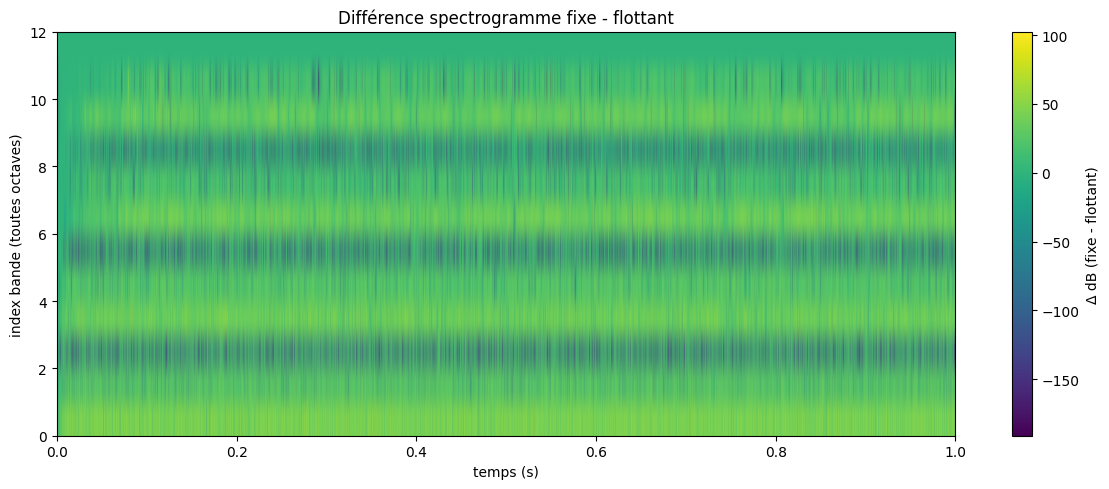

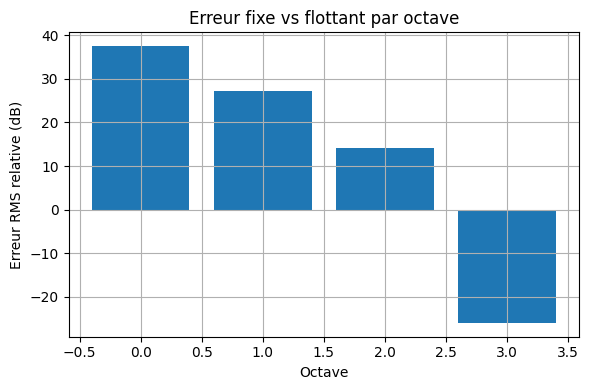

In [63]:
metrics = analyze_fixed_vs_float(
    out_fp,
    out_fx,
    fs=fs,
    n_octaves=n_octaves,
    base_len=len(x),
)


# Test Audio

In [52]:
def load_audio_test(
    filename,
    fs_target,
    duration_s=0.2,
):
    """
    Charge un fichier audio, le convertit en mono,
    le resample si nécessaire, normalise et tronque.
    """
    x, fs_wav = sf.read(filename)

    # mono
    if x.ndim > 1:
        x = x[:, 0]

    # suppression DC (important en fixe)
    x = x - np.mean(x)

    # resample si nécessaire
    if fs_wav != fs_target:
        x = resample_poly(x, fs_target, fs_wav)

    # normalisation soft (évite la saturation fixe)
    x = x / (np.max(np.abs(x)) + 1e-12)

    # tronquage
    N = int(duration_s * fs_target)
    x = x[:N]

    return x


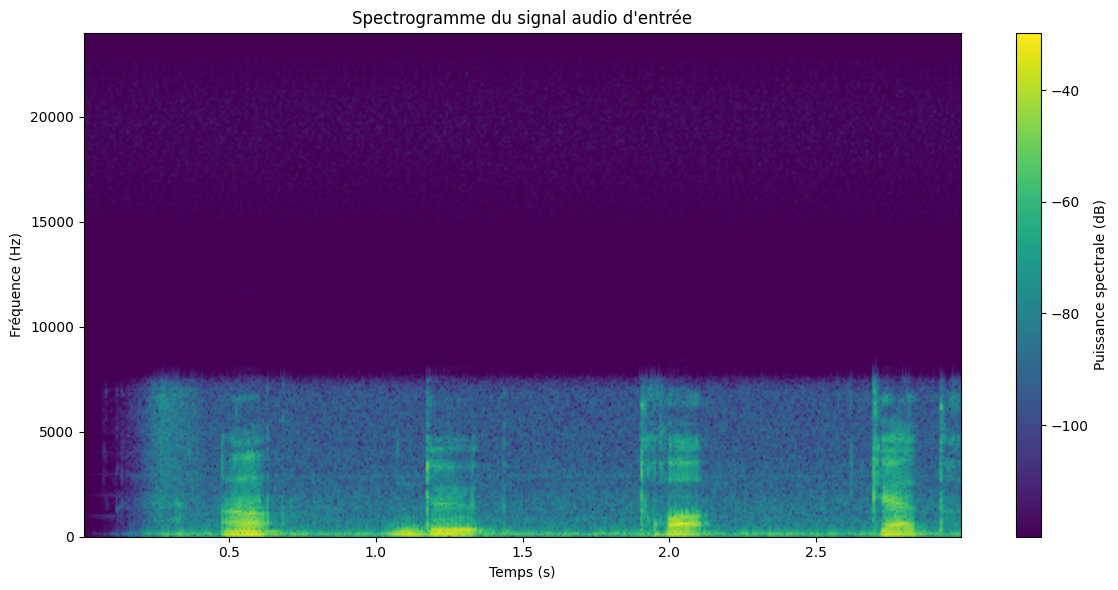

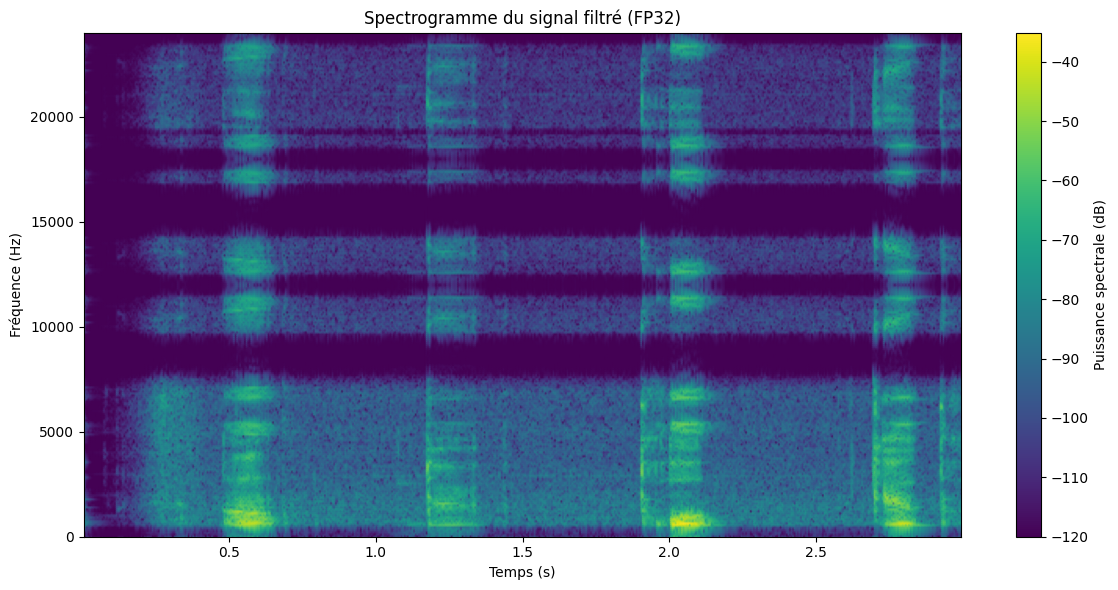

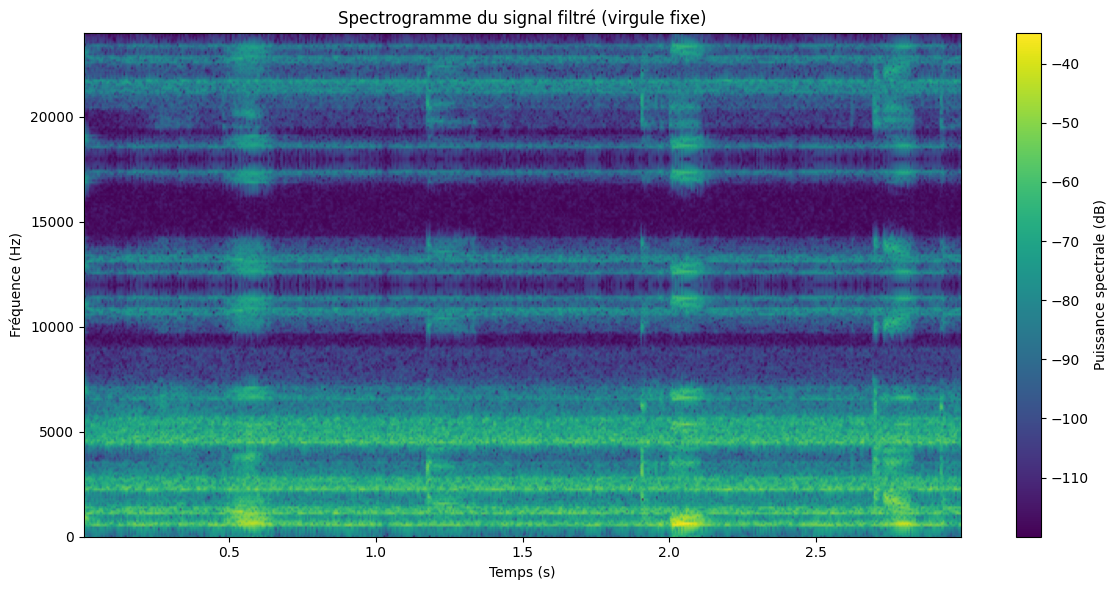

In [54]:
# paramètres
fs = 48000
n_octaves = 4

# chargement audio
x = load_audio_test("test.wav", fs_target=fs, duration_s=3)

# Spectrogramme du signal d'entrée
plot_spectrogram_db(x, fs, "Spectrogramme du signal audio d'entrée")

# === FP32 ===
out_fp = simulate_multirate_paper(
    x, fs, oct_filters_fp, decim_fp
)
S_fp = build_spectrogram_matrix(
    out_fp, n_octaves=n_octaves, base_len=len(x)
)
y_reconstructed_fp = np.sum(S_fp, axis=0)  # Somme de toutes les bandes
plot_spectrogram_db(y_reconstructed_fp, fs, "Spectrogramme du signal filtré (FP32)")

# === FIXE ===
out_fx = simulate_multirate_paper(
    x, fs, oct_filters_fx, decim_fx
)
S_fx = build_spectrogram_matrix(
    out_fx, n_octaves=n_octaves, base_len=len(x)
)
y_reconstructed_fx = np.sum(S_fx, axis=0)  # Somme de toutes les bandes
plot_spectrogram_db(y_reconstructed_fx, fs, "Spectrogramme du signal filtré (virgule fixe)")


=== Analyse temporelle par octave ===
Octave 0 | RMS FP=2.453e-03 | RMS FX=1.261e-02 | RMS err=1.238e-02 | SNR=-14.06 dB
Octave 1 | RMS FP=4.763e-03 | RMS FX=1.320e-02 | RMS err=1.240e-02 | SNR=-8.31 dB
Octave 2 | RMS FP=8.884e-03 | RMS FX=1.473e-02 | RMS err=1.204e-02 | SNR=-2.64 dB
Octave 3 | RMS FP=2.306e-02 | RMS FX=2.798e-02 | RMS err=1.505e-02 | SNR=3.71 dB

=== Erreur d’énergie par bande ===
Oct 0 | Bande 0 | ΔE = 16.17 dB
Oct 0 | Bande 1 | ΔE = 3.61 dB
Oct 0 | Bande 2 | ΔE = 4.03 dB
Oct 1 | Bande 0 | ΔE = 15.45 dB
Oct 1 | Bande 1 | ΔE = 1.04 dB
Oct 1 | Bande 2 | ΔE = 0.08 dB
Oct 2 | Bande 0 | ΔE = 6.34 dB
Oct 2 | Bande 1 | ΔE = 0.57 dB
Oct 2 | Bande 2 | ΔE = 0.04 dB
Oct 3 | Bande 0 | ΔE = 1.61 dB
Oct 3 | Bande 1 | ΔE = 0.27 dB
Oct 3 | Bande 2 | ΔE = 3.42 dB


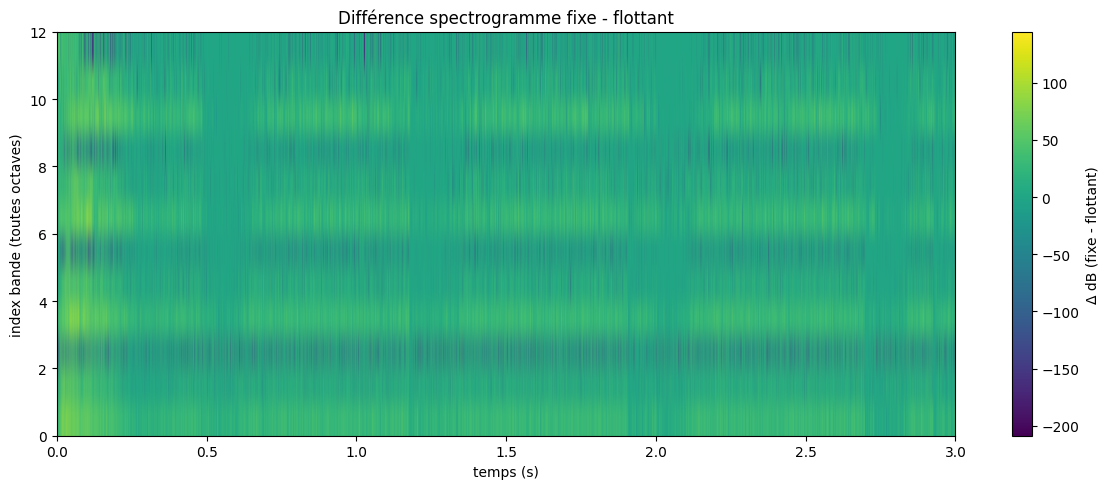

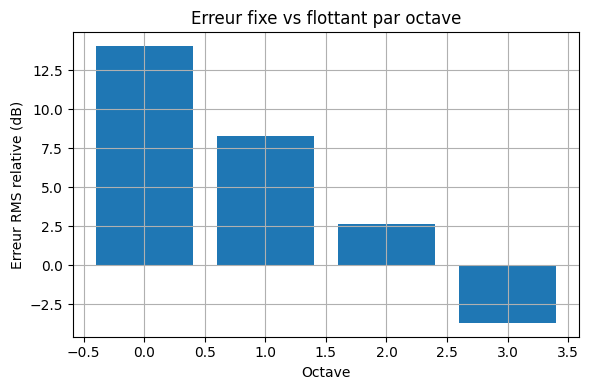

Octave 0 | RMS FP = 2.453e-03 | RMS FX = 1.261e-02 | RMS err = 1.238e-02 | Erreur = 14.06 dB
Octave 1 | RMS FP = 4.763e-03 | RMS FX = 1.320e-02 | RMS err = 1.240e-02 | Erreur = 8.31 dB
Octave 2 | RMS FP = 8.884e-03 | RMS FX = 1.473e-02 | RMS err = 1.204e-02 | Erreur = 2.64 dB
Octave 3 | RMS FP = 2.306e-02 | RMS FX = 2.798e-02 | RMS err = 1.505e-02 | Erreur = -3.71 dB


In [56]:
metrics = analyze_fixed_vs_float(
    out_fp,
    out_fx,
    fs=fs,
    n_octaves=n_octaves,
    base_len=len(x),
)

for m in metrics:
    print(
        f"Octave {m['octave']} | "
        f"RMS FP = {m['rms_fp']:.3e} | "
        f"RMS FX = {m['rms_fx']:.3e} | "
        f"RMS err = {m['rms_err']:.3e} | "
        f"Erreur = {m['err_db']:.2f} dB"
    )
